## Competition documentation

[Linking Writing Processes to Writing Quality](https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality)

## Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from pathlib import Path
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
SEED=7

## Reading data

In [2]:
path = Path('../input/linking-writing-processes-to-writing-quality')
path_keystroke_measures = Path('../input/keystroke-measures')

In [3]:
os.listdir(path)

['sample_submission.csv',
 'test_logs.csv',
 'train_scores.csv',
 'train_logs.csv']

In [4]:
test_logs = pd.read_csv(path/'test_logs.csv')
train_scores = pd.read_csv(path/'train_scores.csv')

with open(path_keystroke_measures/'train_logs.pkl', 'rb') as file:
    train_logs = pd.read_pickle(file)

DEBUG = False   
    
if DEBUG:
    num_essays = 100
    train_logs = train_logs[train_logs.id.isin(train_logs.id.unique()[:num_essays])]
    train_scores = train_scores[train_scores.id.isin(train_logs.id.unique()[:num_essays])]
    print(f"Debug mode activated. Utilizing {num_essays} essays from train_logs and train_scores.")
else:
    print("Debug mode has been deactivated. The whole dataset of train_logs and train_scores will be utilized:",
          f"{train_logs.id.nunique()} essays.")

Debug mode has been deactivated. The whole dataset of train_logs and train_scores will be utilized: 2471 essays.


## EDA

### test_logs

`test_logs` includes data for 3 essays. It is meant to serve as an example to illustrate the format.

The real `test_logs` will replace it when submissions are scored, according to the competition documentation. 

### **score** - target variable

The average score is 3.71. The median is 4.0
There are 12 possible values for essay score: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0] 




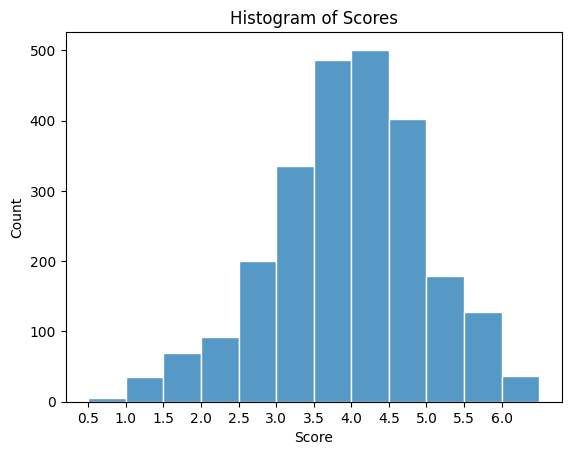

The score 0.5 is represented by only five data points, all of which register as zero.



In [5]:
print(f'The average score is {train_scores.score.mean().round(2)}. The median is {train_scores.score.median()}')

sns.histplot(train_scores.score, bins=12, edgecolor='white', binwidth=0.4999)
xticks = [0.5 * i for i in range(1, 13)]
plt.xticks(xticks)
plt.xlabel('Score');
plt.ylabel('Count');
plt.title('Histogram of Scores')

print(f'There are {train_scores.score.nunique()} possible values for essay score:', 
      sorted(train_scores.score.unique()), '\n\n')

# train_scores.score = train_scores.score*2 - 1

# train_scores.score = pd.Categorical(train_scores.score, sorted(train_scores.score.unique()), ordered=True)
plt.show()
print('The score 0.5 is represented by only five data points, all of which register as zero.\n')
# print('Changing type to Categorical:\n', train_scores.score.unique())

### train_logs

In [6]:
train_logs.head()

id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  num_events  \
0  Leftclick  Leftclick    NoChange                0           0        2557   
1  Leftclick  Leftclick    NoChange                0           0        2557   
2      Shift      Shift    NoChange                0           0        2557   
3          q          q           q                1           1        2557   
4          q          q           q                2           1        2557   

   total_time_mins  total_action_time_mins  mean_action_time_ms  \
0             30.0                     5.0                116.2   
1             30.0                     5.0                116.2   
2             30.0                     5.0                116.2   
3             30.0                     5.0                116.2   
4             30.0                     5.0                116.2   

   chars_product  chars_per_min_product  chars_process  chars_per_min_process  \
0         1528.0                   50.9         2017.0                   67.2   
1         1528.0                   50.9         2017.0                   67.2   
2         1528.0                   50.9         2017.0                   67.2   
3         1528.0                   50.9         2017.0                   67.2   
4         1528.0                   50.9         2017.0                   67.2   

   words_per_min_product  words_per_min_process  sentences_per_min_process  \
0                    8.5                   11.6                        0.7   
1                    8.5                   11.6                        0.7   
2                    8.5                   11.6                        0.7   
3                    8.5                   11.6                        0.7   
4                    8.5                   11.6                        0.7   

   sentences_per_min_product  paragraphs_per_min_process  num_pauses  \
0                       21.8                         0.1       124.0   
1                       21.8                         0.1       124.0   
2                       21.8                         0.1       124.0   
3                       21.8                         0.1       124.0   
4                       21.8                         0.1       124.0   

   pauses_per_min  pause_time_proportion_perc  mean_pause_length  \
0             4.1                        65.7             9537.1   
1             4.1                        65.7             9537.1   
2             4.1                        65.7             9537.1   
3             4.1                        65.7             9537.1   
4             4.1                        65.7             9537.1   

   mean_pause_length_btw_paragraphs  mean_pause_length_btw_sentences  \
0                           19790.5                           8271.9   
1                           19790.5                           8271.9   
2                           19790.5                           8271.9   
3                           19790.5                           8271.9   
4                           19790.5                           8271.9   

   mean_pause_length_btw_words  mean_pause_length_w_in_words  deletions  \
0                       1835.9                         780.7       96.0   
1                       1835.9                         780.7       96.0   
2                       1835.9                         780.7       96.0   
3                       1835.9                         780.7       96.0   
4                       1835.9                         780.7       96.0   

   d

#### train_logs --> simplified_train_logs

Ultimately, we will retain only a single row for each essay:

In [7]:
redundant_vars = ['num_pauses', 'chars_process', 'chars_product']
train_logs.drop(redundant_vars, axis=1, inplace=True)

original_cols_ex_id = ['event_id', 'down_time', 'up_time', 'action_time', 'activity',
                       'down_event', 'up_event', 'text_change', 'cursor_position', 'word_count']

simplified_train_logs = train_logs.drop(original_cols_ex_id, axis=1)

simplified_train_logs.drop_duplicates(inplace=True)
simplified_train_logs.reset_index(drop=True, inplace=True)

print("\nNumber of features in train_logs vs simplified_train_logs:",len(train_logs.columns), 'vs', len(simplified_train_logs.columns), '\n')
print("Number of rows in train_logs vs simplified_train_logs:",train_logs.shape[0], 'vs', simplified_train_logs.shape[0], '\n')
simplified_train_logs.head()


Number of features in train_logs vs simplified_train_logs: 46 vs 36 

Number of rows in train_logs vs simplified_train_logs: 8405898 vs 2471 



id  num_events  total_time_mins  total_action_time_mins  \
0  001519c8        2557             30.0                     5.0   
1  0022f953        2454             29.8                     4.6   
2  0042269b        4136             29.5                     7.0   
3  0059420b        1556             23.4                     3.2   
4  0075873a        2531             27.7                     5.2   

   mean_action_time_ms  chars_per_min_product  chars_per_min_process  \
0                116.2                   50.9                   67.2   
1                112.2                   56.2                   65.1   
2                101.8                   87.7                  119.4   
3                121.8                   49.3                   56.3   
4                123.9                   51.4                   70.1   

   words_per_min_product  words_per_min_process  sentences_per_min_process  \
0                    8.5                   11.6                        0.7   
1                   10.7                   12.4                        0.6   
2                   13.7                   18.6                        0.7   
3                    8.8                   10.4                        0.6   
4                    9.1                   12.2                        0.9   

   sentences_per_min_product  paragraphs_per_min_process  pauses_per_min  \
0                       21.8                         0.1             4.1   
1                       17.9                         0.2             2.7   
2                       20.9                         0.6             2.6   
3                       13.0                         0.1             3.7   
4                       24.7                         0.4             3.2   

   pause_time_proportion_perc  mean_pause_length  \
0                        65.7             9537.1   
1                        65.8            14521.8   
2                        62.8            14430.7   
3                        54.7             8828.4   
4                        62.9            11880.3   

   mean_pause_length_btw_paragraphs  mean_pause_length_btw_sentences  \
0                           19790.5                           8271.9   
1                               NaN                           3197.7   
2                            4804.0                           3315.3   
3                           61128.7                          14315.4   
4                           37640.0                          12462.1   

   mean_pause_length_btw_words  mean_pause_length_w_in_words  deletions  \
0                       1835.9                         780.7       96.0   
1                       1207.0                         784.3       82.0   
2                       1637.2                         492.0       97.0   
3                       2824.9                        1199.7       66.0   
4                       2293.4                        1212.0       58.0   

   deletions_per_min  mean_length_deletions  distant_deletions  \
0                3.2                    4.3                3.0   
1                2.8                    3.2                8.0   
2                3.3                    4.5                5.0   
3                2.8                    2.3                1.0   
4                2.1                    8.9                8.0   

   deletions_proportion_perc  imm_deletions  distant_deletion_ratio  \
0                        8.5           93.0                     0.0   
1                        0.0           74.0                     0.1   
2                        0.0           92.0                     0.1   
3                        0.0           65.0                     0.0   
4                        0.0           50.0                     0.1   

   product_process_ratio  p_bursts  r_bursts  p_bursts_per_min  \
0                    0.8      16.0       7.0               0.5   
1                    0.9       8.0      20.0               0.3   
2                    0

#### down_time, up_time, action_time

These 3 features have been used to create several other features in the `keystroke-measures` file, 

namely `total_time_mins, total_action_time_mins, mean_action_time_ms` and features related to pauses, deletions and bursts.

#### activity

Values like `Move From [x1, y1] To [x2, y2]` in the field `activity` refer to events where a section of text has been moved to a new location.

In [8]:
print("The number of events with this kind of activity is only:", 
      train_logs[train_logs['activity'].str.startswith('Move From [')].activity.count())

The number of events with this kind of activity is only: 46


In [9]:
print("Value counts for other types of activity are:\n\n", 
      train_logs[~train_logs['activity'].str.startswith('Move')].activity.value_counts())

Value counts for other types of activity are:

 activity
Input            6726796
Remove/Cut        970158
Nonproduction     703851
Replace             4448
Paste                599
Name: count, dtype: int64


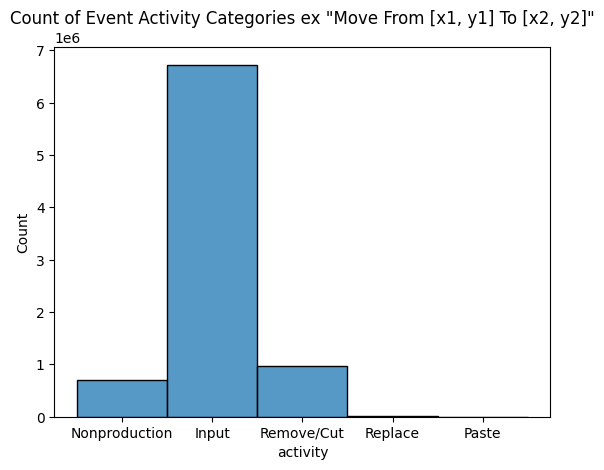

In [10]:
sns.histplot(train_logs[~train_logs['activity'].str.startswith('Move')].activity);
plt.title('Count of Event Activity Categories ex "Move From [x1, y1] To [x2, y2]"');

#### down_event, up_event, text_change 

The documentation specifies that all alphanumeric character inputs have been substituted with the "anonymous" character `q`.

In [11]:
train_logs.text_change.value_counts()[:10]

text_change
q           6128208
            1376829
NoChange     703851
.             67797
,             54797
\n            27977
'             13192
"              4659
-              4492
?              3507
Name: count, dtype: int64

In [12]:
train_logs.down_event.unique()

array(['Leftclick', 'Shift', 'q', 'Space', 'Backspace', '.', ',', 'Enter',
       'ArrowLeft', "'", ';', 'ArrowRight', '-', '?', 'Tab', '"',
       'ArrowUp', 'ArrowDown', 'Rightclick', '=', 'CapsLock', 'Control',
       'c', 'v', '/', 'Delete', ':', 'z', '[', '$', '(', ')', '+', 'Home',
       'End', '\\', 'Meta', '*', '&', 'AudioVolumeMute', 'x', '!',
       'Insert', 'MediaPlayPause', 'NumLock', '%', 'V', '>', 'Alt',
       'AudioVolumeUp', 'ContextMenu', 'AudioVolumeDown', 'a', '<',
       'PageDown', ']', 'Middleclick', '@', 'F12', 'j', '\x96', 'Dead',
       't', 's', 'n', 'y', '{', 'ScrollLock', '¿', 'Process', '}',
       'MediaTrackPrevious', 'MediaTrackNext', 'F3', '^', 'Unidentified',
       'Cancel', '2', 'i', 'd', 'r', 'e', '`', '\x9b', 'm', '#', '~',
       'PageUp', 'T', 'A', 'b', 'S', 'ModeChange', '_', 'Escape', 'F11',
       'Unknownclick', 'AltGraph', 'F10', 'h', 'F15', 'Clear', 'OS', 'F',
       'C', 'o', 'Ä±', 'f', 'u', 'w', 'p', 'g', 'M', 'l', '|',
       'â\x80\x

In [13]:
train_logs.down_event.value_counts()[:10]

down_event
q             5365319
Space         1207128
Backspace      964089
Shift          334227
ArrowRight     121338
Leftclick       91126
ArrowLeft       63217
.               59586
,               46806
ArrowDown       30874
Name: count, dtype: int64

- **Hypothesis to explore**: Better handling of keyboard shortcuts could be associated with higher competence

In [14]:
# We will focus on 'Control key' events
train_logs['num_control_key'] = train_logs.groupby('id')['down_event'].transform(lambda x: (x == 'Control').sum())

simplified_train_logs = simplified_train_logs.merge(train_logs[['id', 'num_control_key']].drop_duplicates(), on='id', how='left')
simplified_train_logs.drop('id', axis=1, inplace=True)

In [15]:
# Verifying that the choice between 'down_event' and 'up_event' is inconsequential
is_choice_irrelevant = (train_logs.groupby('id')['down_event'].transform(lambda x: (x == 'Control').sum())
                        == train_logs.groupby('id')['up_event'].transform(lambda x: (x == 'Control').sum())).mean()

print(f"The result of is_choice_irrelevant: {bool(is_choice_irrelevant)},", 
      "confirms that the values for 'down_event' and 'up_event' coincide when either of them is 'Control'.")

The result of is_choice_irrelevant: True, confirms that the values for 'down_event' and 'up_event' coincide when either of them is 'Control'.


Percentage of essays with at least one event ('down_event') involving the Control key: 18.5%




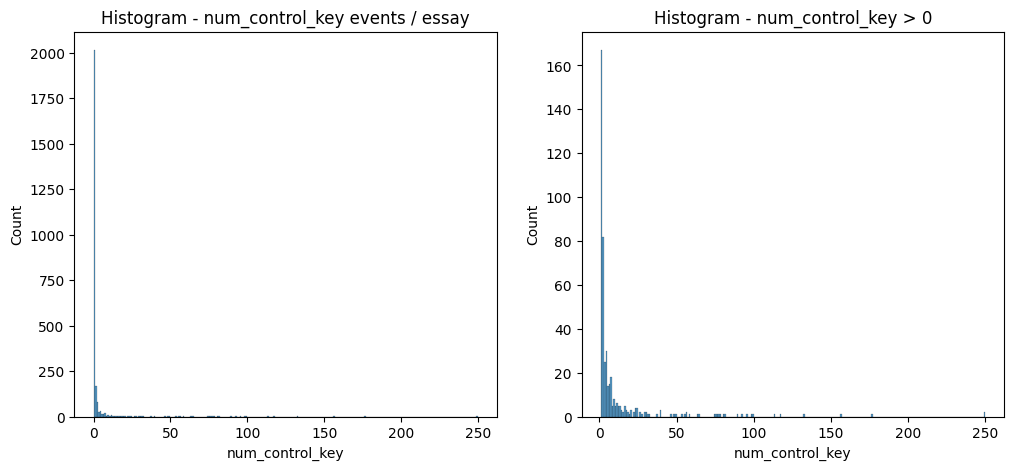

In [16]:
# Observing values of new feature 'num_control_key'
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(simplified_train_logs.num_control_key, binwidth=1, ax=axes[0])
axes[0].set_title('Histogram - num_control_key events / essay')

sns.histplot(simplified_train_logs[simplified_train_logs.num_control_key > 0].num_control_key, binwidth=1, ax=axes[1])
axes[1].set_title('Histogram - num_control_key > 0');

print("Percentage of essays with at least one event ('down_event') involving the Control key:",
      f"{np.round(100 * len(simplified_train_logs[simplified_train_logs.num_control_key != 0]) / len(simplified_train_logs), 1)}%\n\n")

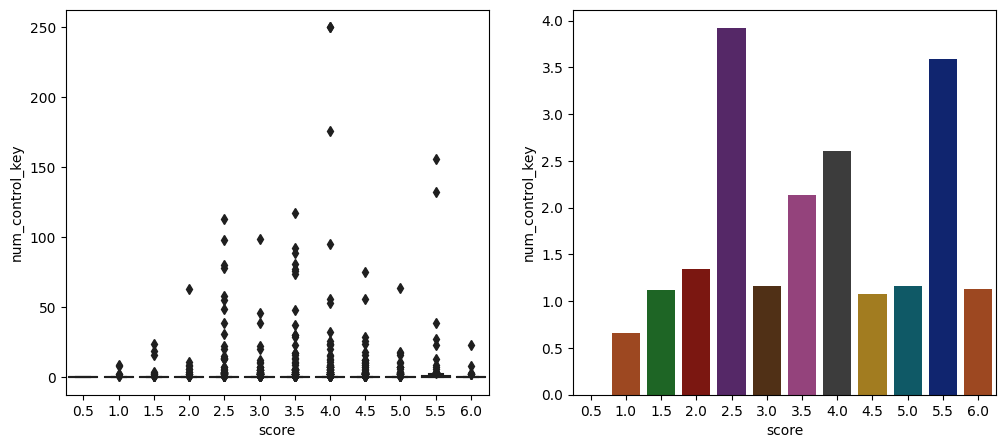

In [17]:
# Checking correlation of 'num_control_key' vs 'score'
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x=train_scores.score, y=simplified_train_logs.num_control_key, palette='dark', ax=axes[0]);
sns.barplot(x=train_scores.score, y=simplified_train_logs.num_control_key, ci=None, palette='dark', ax=axes[1]);

We can infer that there is no discernible correlation between use of 'Control key' vs 'score'. 

Nevertheless, we will keep the feature for potential interactions with other features.

#### num_events

The average number of events per essay is 3402.0


<Axes: xlabel='num_events', ylabel='Count'>

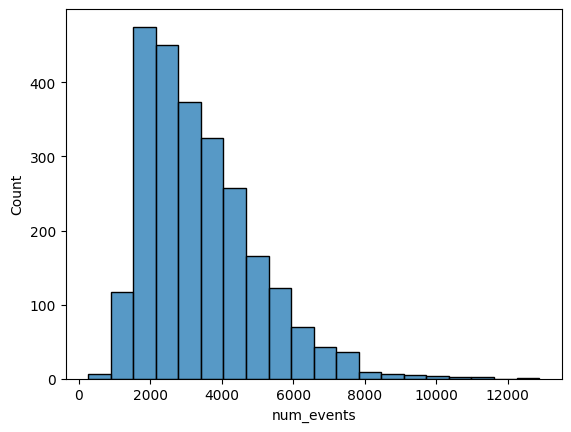

In [18]:
print(f'The average number of events per essay is {np.round(simplified_train_logs.num_events.mean(), 0)}')
sns.histplot(data=simplified_train_logs, x='num_events', bins=20)

For machine learning models, it becomes challenging to effectively learn and make accurate predictions when certain features

exhibit a range of values with infrequent occurrences. We will try some approaches to mitigate that handicap, later on.

Is there a correlation between `num_events` and `score`?


				The graph on the right illustrates the average value of num_events for each score.




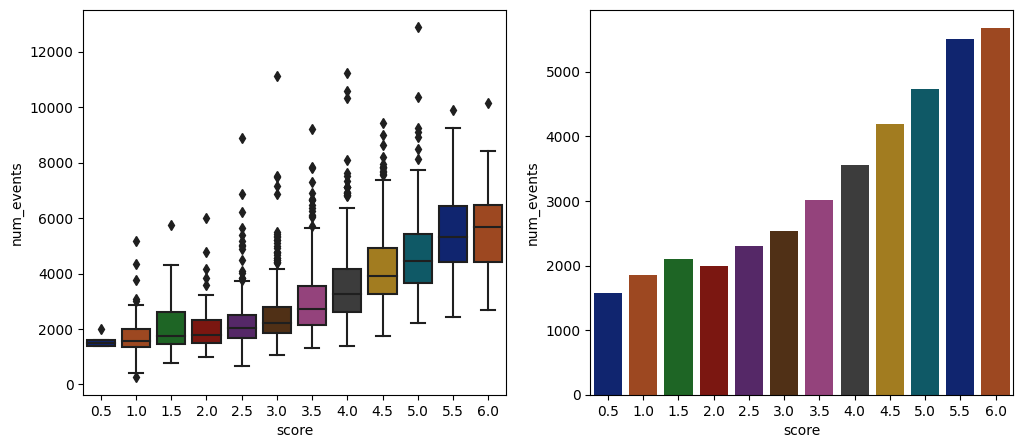

In [19]:
print("\n\t\t\t\tThe graph on the right illustrates the average value of num_events for each score.\n\n")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x=train_scores.score, y=simplified_train_logs.num_events, palette='dark', ax=axes[0]);
sns.barplot(x=train_scores.score, y=simplified_train_logs.num_events, ci=None, palette='dark', ax=axes[1]);

Indeed, there appears to be a positive correlation between `num_events` and `score`.

Now, let's check possible correlations between the target variable `score` and the rest of features:

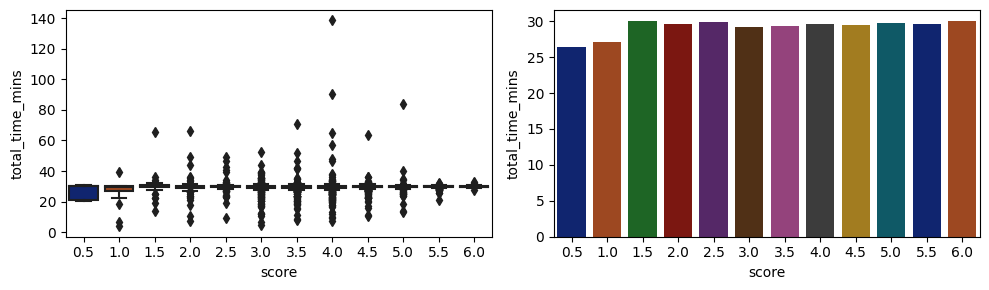

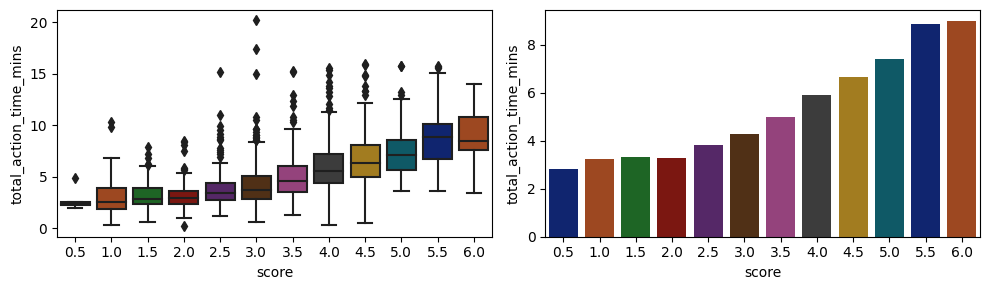

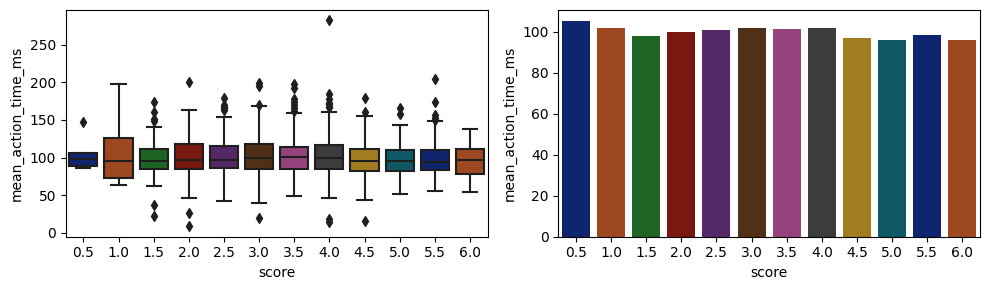

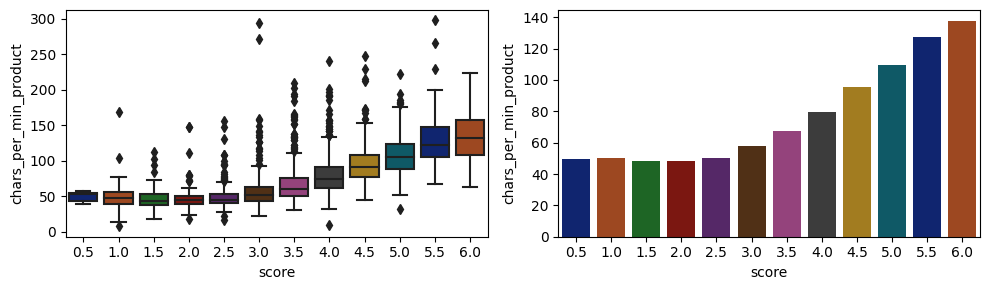

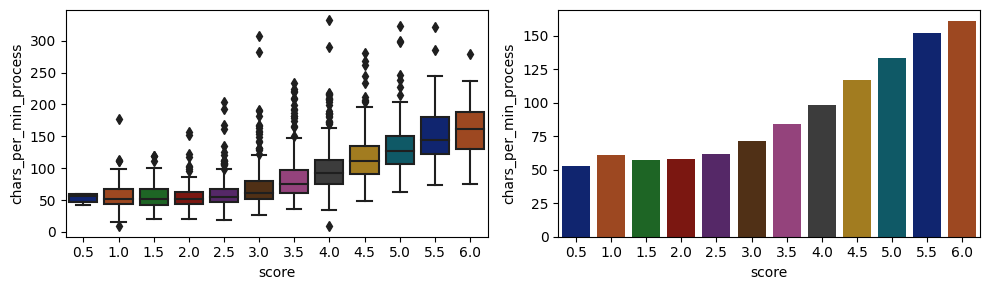

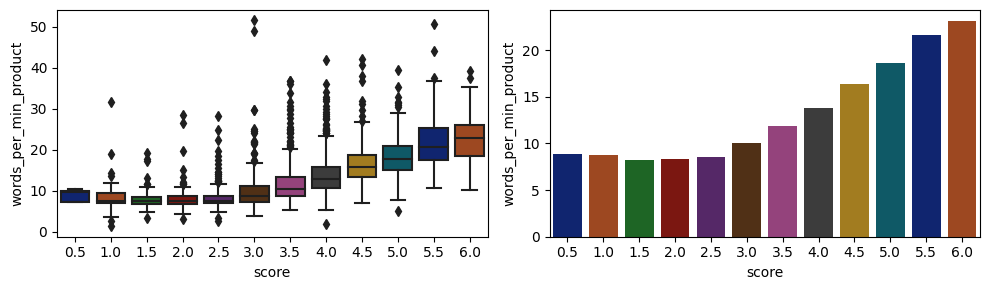

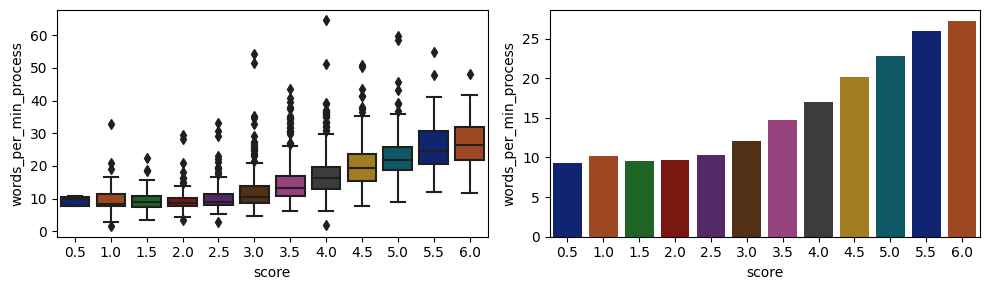

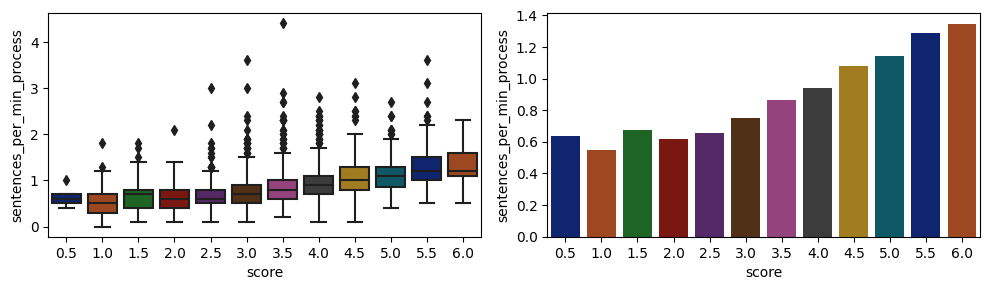

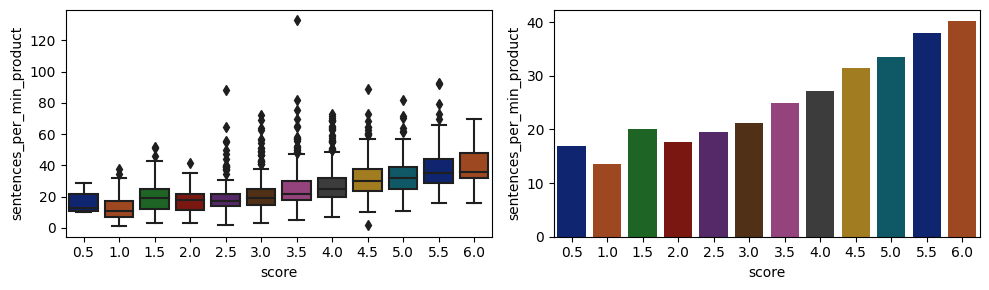

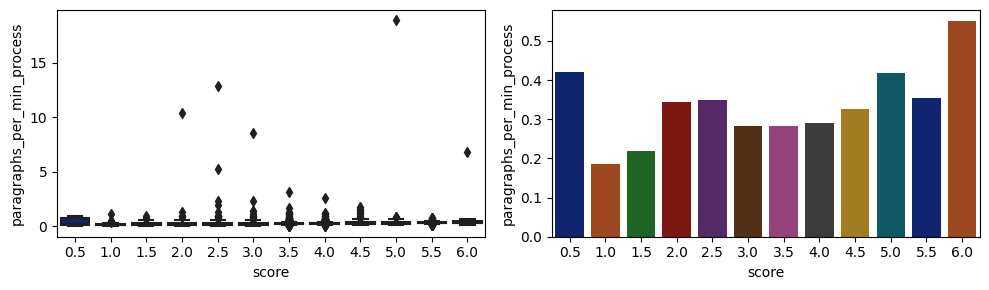

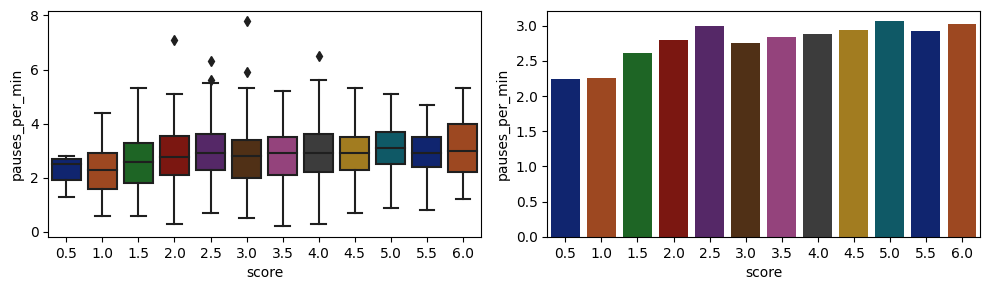

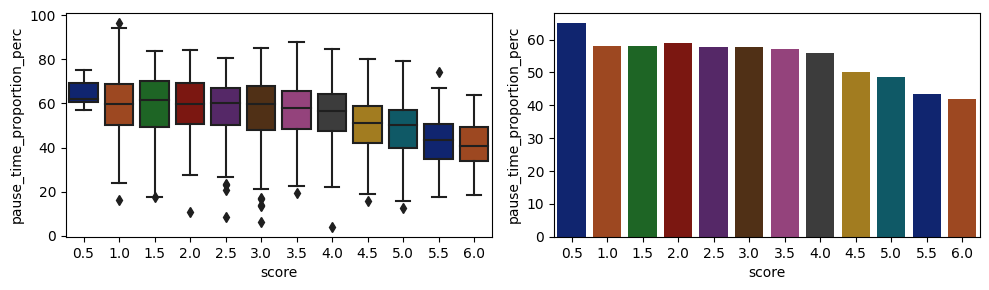

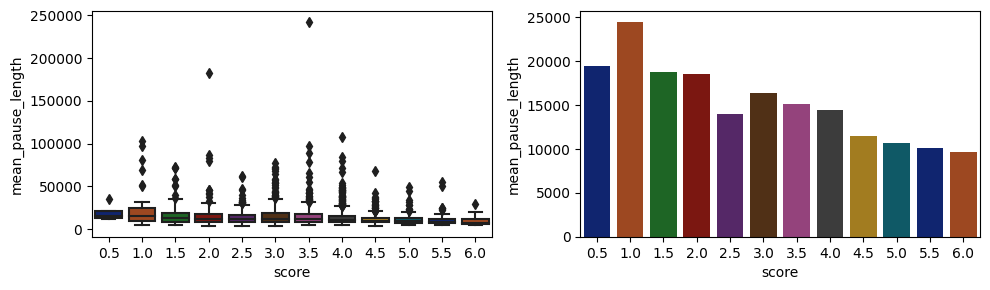

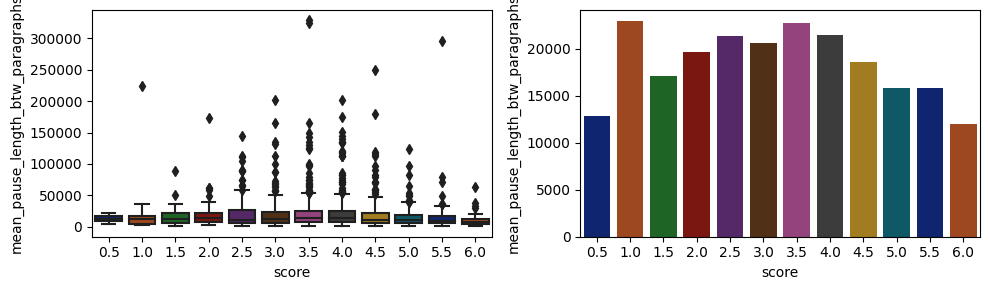

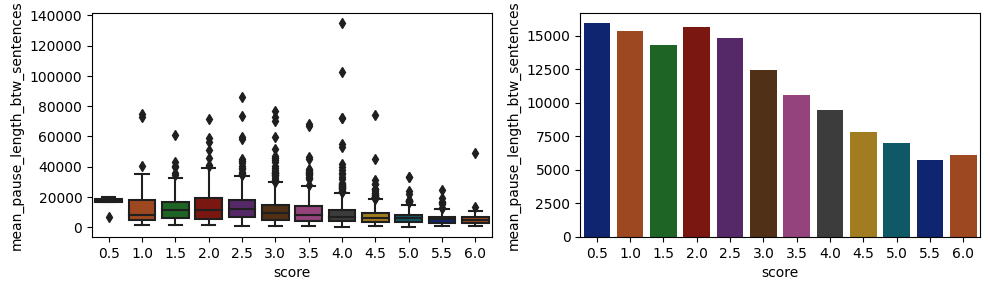

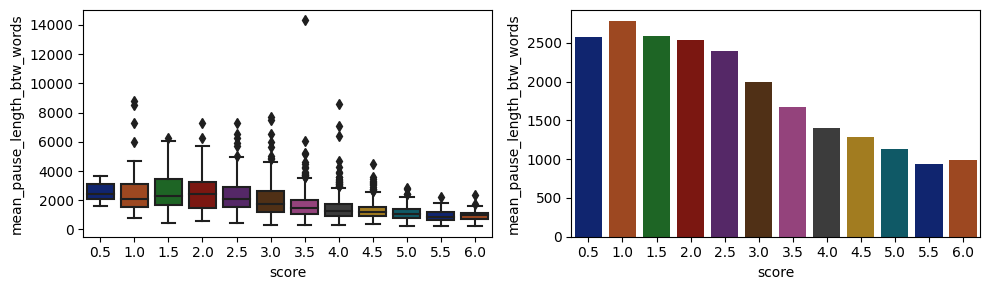

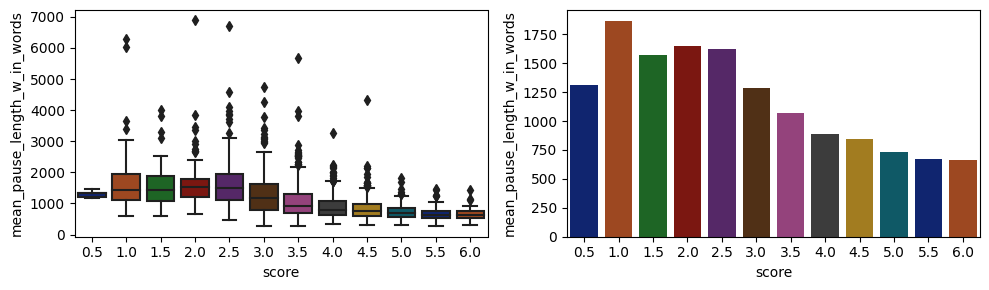

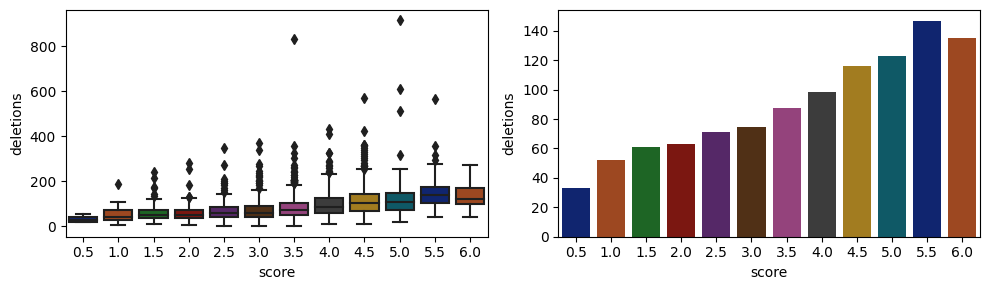

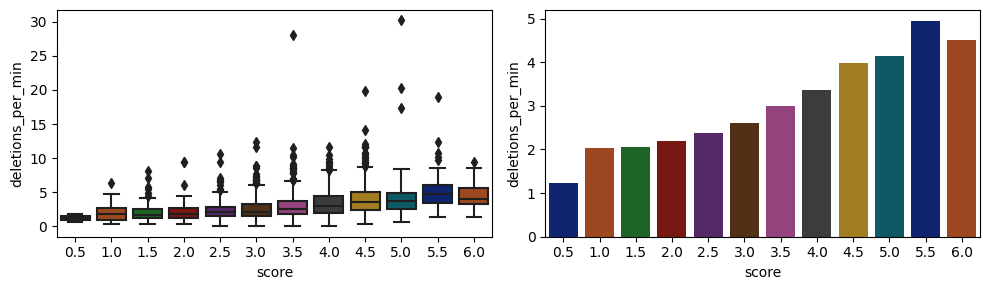

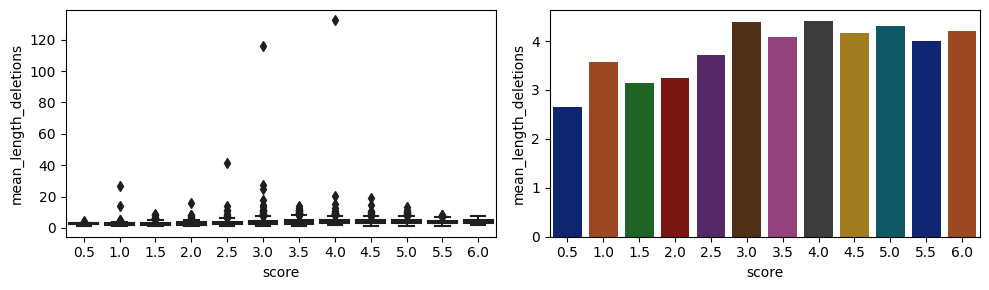

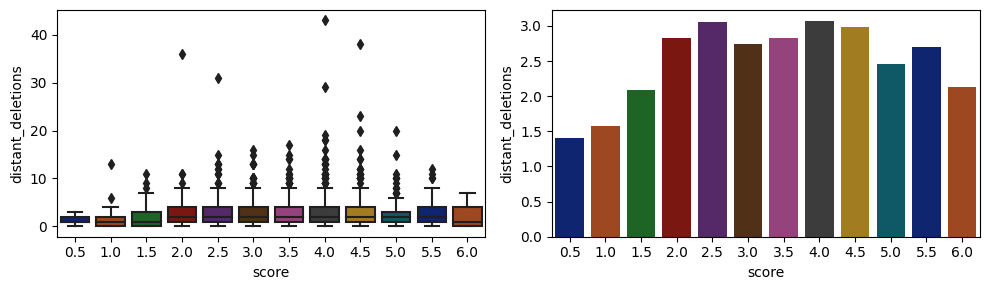

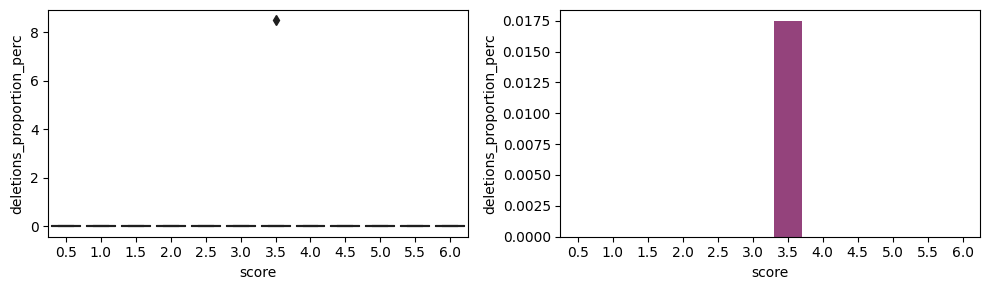

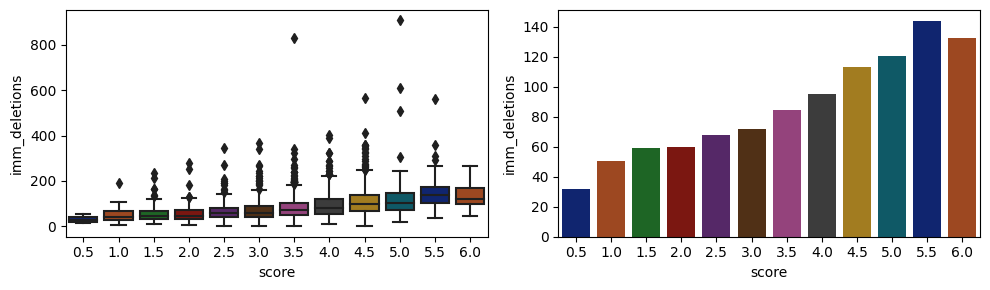

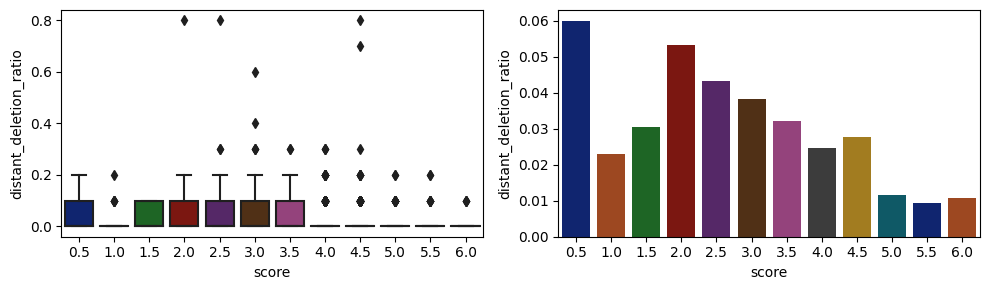

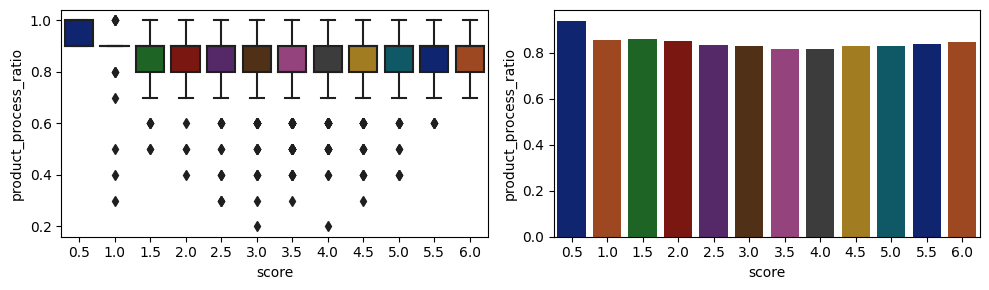

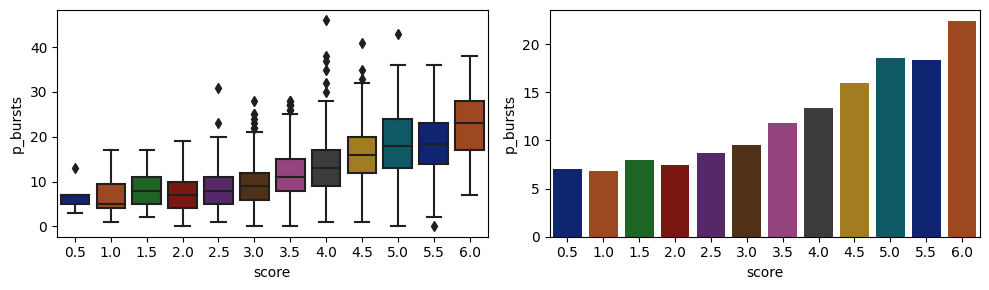

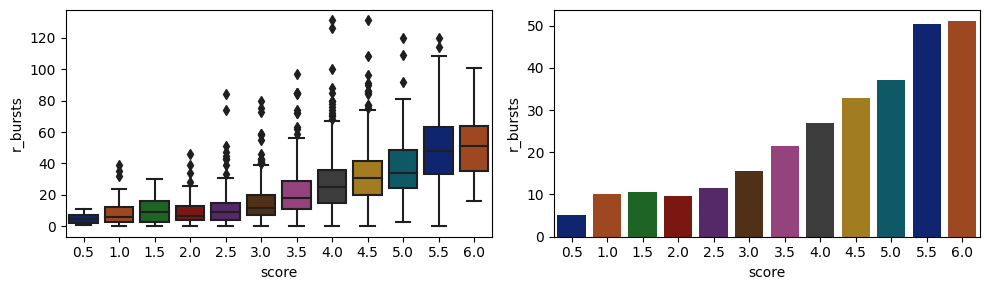

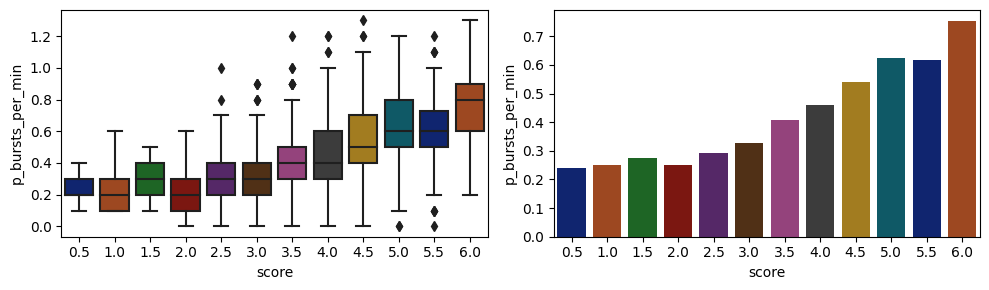

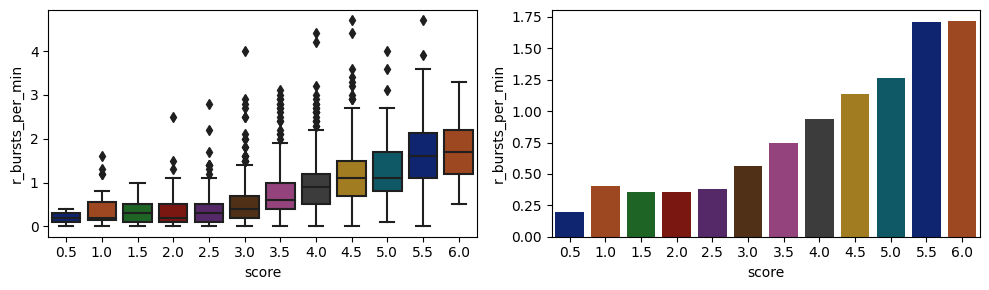

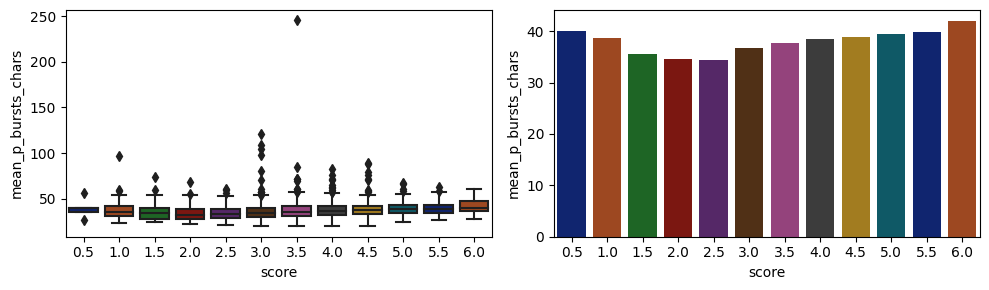

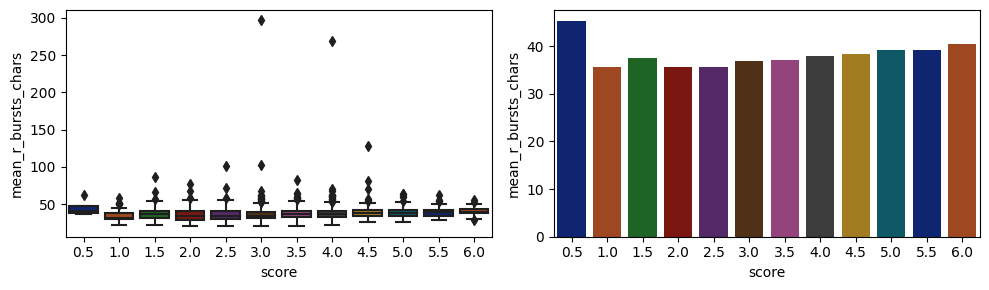

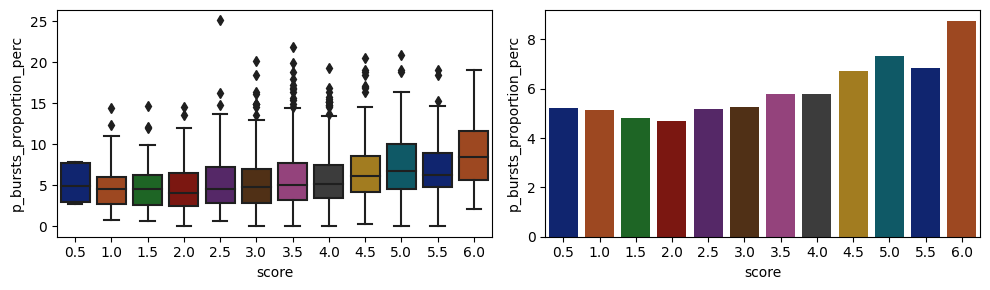

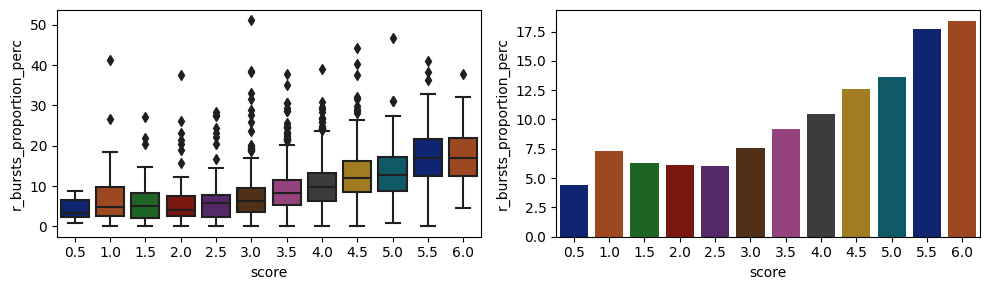

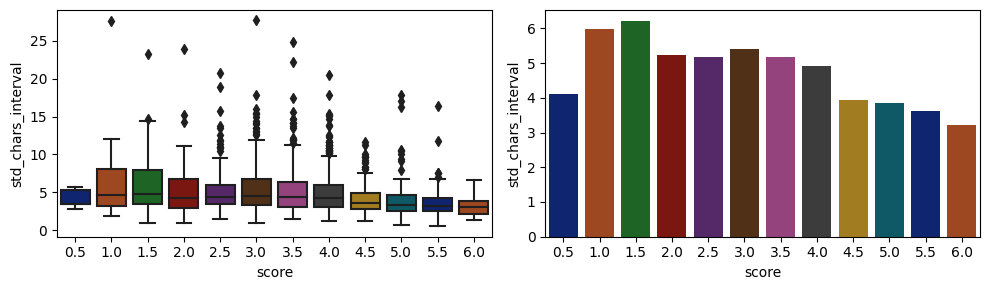

In [20]:
for column in simplified_train_logs.columns:
    if column not in ('num_control_key', 'num_events'):
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        sns.boxplot(x=train_scores.score, y=simplified_train_logs[column], palette='dark', ax=axes[0]);
        sns.barplot(x=train_scores.score, y=simplified_train_logs[column], ci=None, palette='dark', ax=axes[1]);
        plt.tight_layout()
        plt.show()

We can observe clearly some positive correlations with the features: `total_action_time_mins, chars_per_min_product,`

`chars_per_min_process, words_per_min_product, words_per_min_process, sentences_per_min_process, sentences_per_min_product,`

`deletions, deletions_per_min, imm_deletions, p_bursts, r_bursts, p_bursts_per_min, r_bursts_per_min,` 

`bursts_proportion_perc, r_bursts_proportion_perc`. There are negative correlations with the following features, as well:

`pause_time_proportion_perc, mean_pause_length_btw_sentences, mean_pause_length_btw_words,` 

`mean_pause_length_w_in_words`.

Afterwards, correlations among those features will be analyzed, and some of them will be descarded as a result.

- **Other hypothesis to explore**:
    *  Best writers have more clarity of thought -> less corrections - keystroke features
    
    *  Best writers spend a larger share of time reviewing - keystroke features

    *  Best writers spend a larger share of time thinking, in pause - keystroke features
    
    *  Best writers spend a larger share of time in bursts (better short-term memory) - keystroke features
    
    *  Volume-related events: tendency to get distracted - tiny sample 
    
    *  Volume-related events: focused if shutting down noise  - tiny sample
    
    *  Those with more periods of inactivity have lower performance - keystroke features
    
<br>


Several hypotheses were rejected due to the limited sample sizes, while others required the introduction of novel features

(keystroke features created in the file 'keystroke-measures'). The efficacy of these newly introduced features will be

assessed by machine learning models to ascertain their utility or lack thereof.

## Feature Engineering

In [21]:
print("Null Values found in simplified_train_logs:\n")
print(simplified_train_logs.isna().sum().sort_values(ascending=False)[:6])
simplified_train_logs.fillna(0, inplace=True)

Null Values found in simplified_train_logs:

mean_pause_length_btw_paragraphs    614
mean_r_bursts_chars                  30
mean_pause_length_btw_sentences      20
mean_p_bursts_chars                   9
mean_length_deletions                 1
distant_deletion_ratio                1
dtype: int64


In [22]:
simplified_train_logs.columns

Index(['num_events', 'total_time_mins', 'total_action_time_mins',
       'mean_action_time_ms', 'chars_per_min_product', 'chars_per_min_process',
       'words_per_min_product', 'words_per_min_process',
       'sentences_per_min_process', 'sentences_per_min_product',
       'paragraphs_per_min_process', 'pauses_per_min',
       'pause_time_proportion_perc', 'mean_pause_length',
       'mean_pause_length_btw_paragraphs', 'mean_pause_length_btw_sentences',
       'mean_pause_length_btw_words', 'mean_pause_length_w_in_words',
       'deletions', 'deletions_per_min', 'mean_length_deletions',
       'distant_deletions', 'deletions_proportion_perc', 'imm_deletions',
       'distant_deletion_ratio', 'product_process_ratio', 'p_bursts',
       'r_bursts', 'p_bursts_per_min', 'r_bursts_per_min',
       'mean_p_bursts_chars', 'mean_r_bursts_chars',
       'p_bursts_proportion_perc', 'r_bursts_proportion_perc',
       'std_chars_interval', 'num_control_key'],
      dtype='object')

In [23]:
# feature clusters
production_cluster = ['chars_per_min_product', 'chars_per_min_process', 'words_per_min_product', 
                      'words_per_min_process', 'sentences_per_min_process', 'sentences_per_min_product',
                      'paragraphs_per_min_process', 'num_control_key', 'num_events', 'total_time_mins',
                      'total_action_time_mins', 'mean_action_time_ms', 'product_process_ratio', 'std_chars_interval']
pause_cluster = ['pauses_per_min', 'pause_time_proportion_perc', 'mean_pause_length', 
                 'mean_pause_length_btw_paragraphs', 'mean_pause_length_btw_sentences',
                 'mean_pause_length_btw_words', 'mean_pause_length_w_in_words']
deletions_cluster = ['deletions', 'deletions_per_min', 'mean_length_deletions', 'distant_deletions', 
                     'deletions_proportion_perc', 'imm_deletions', 'distant_deletion_ratio']
bursts_cluster = ['p_bursts', 'r_bursts', 'p_bursts_per_min', 'r_bursts_per_min',
                  'mean_p_bursts_chars', 'mean_r_bursts_chars', 'p_bursts_proportion_perc', 
                  'r_bursts_proportion_perc']

feature_clusters = [production_cluster, pause_cluster, deletions_cluster, bursts_cluster]
feature_clusters_str = ['production cluster', 'pause cluster', 'deletions cluster', 'bursts cluster']

# Misfits have been added to production_cluster

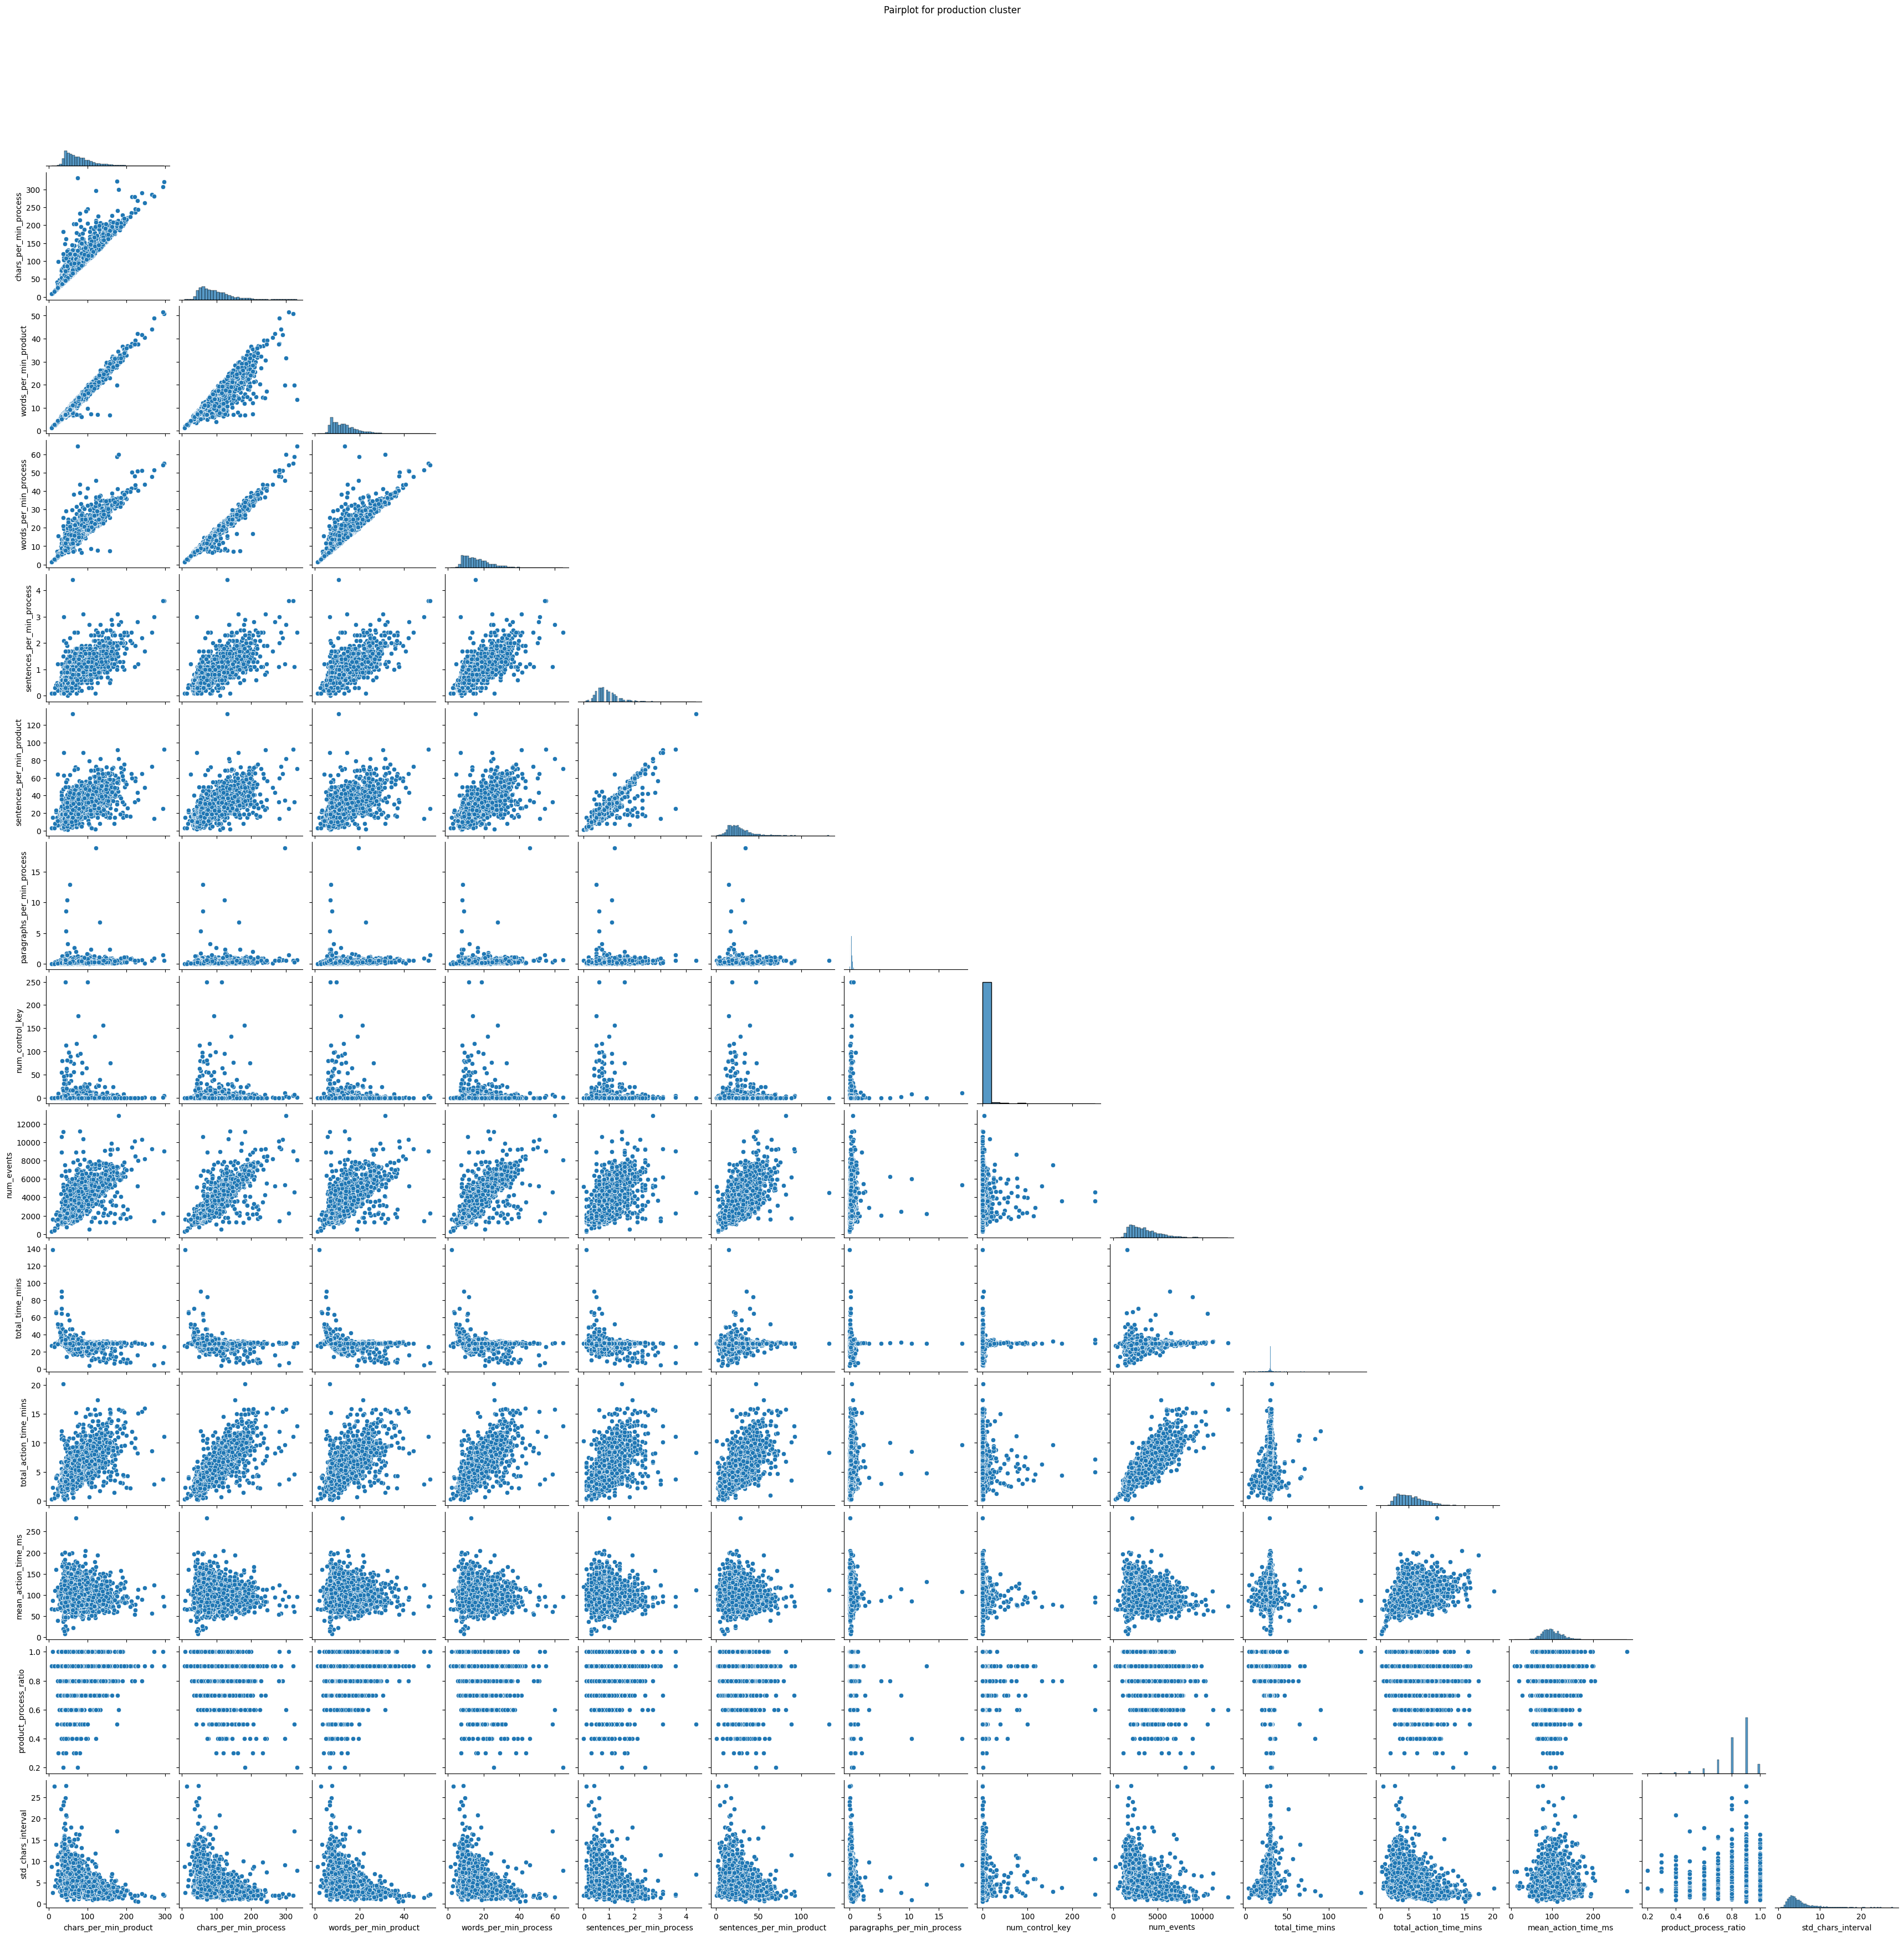

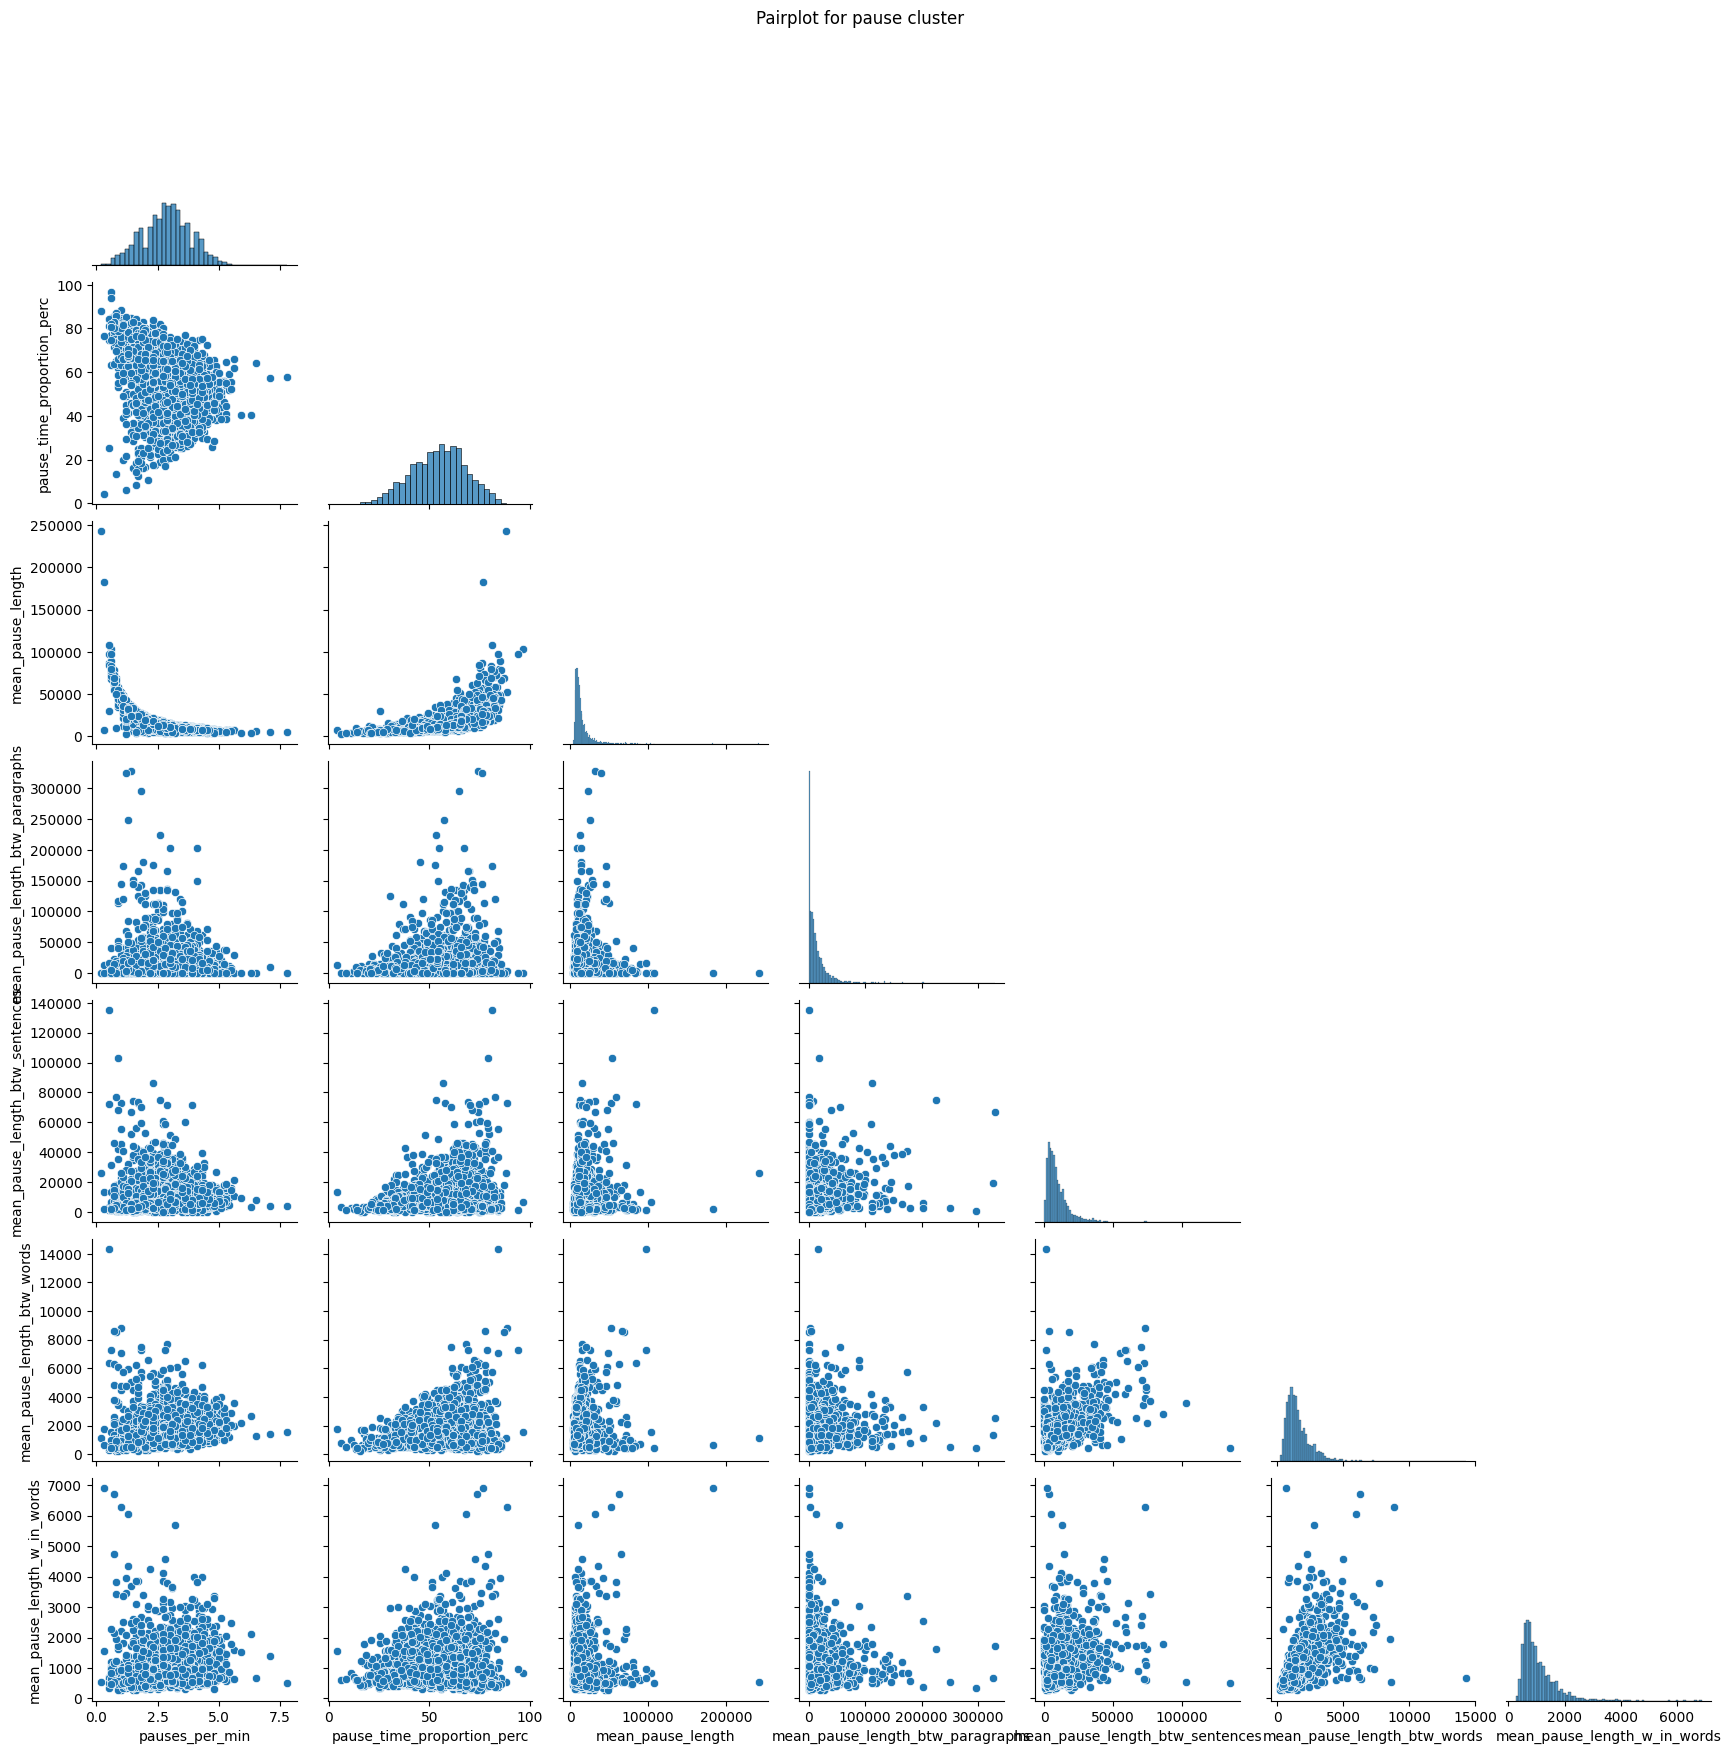

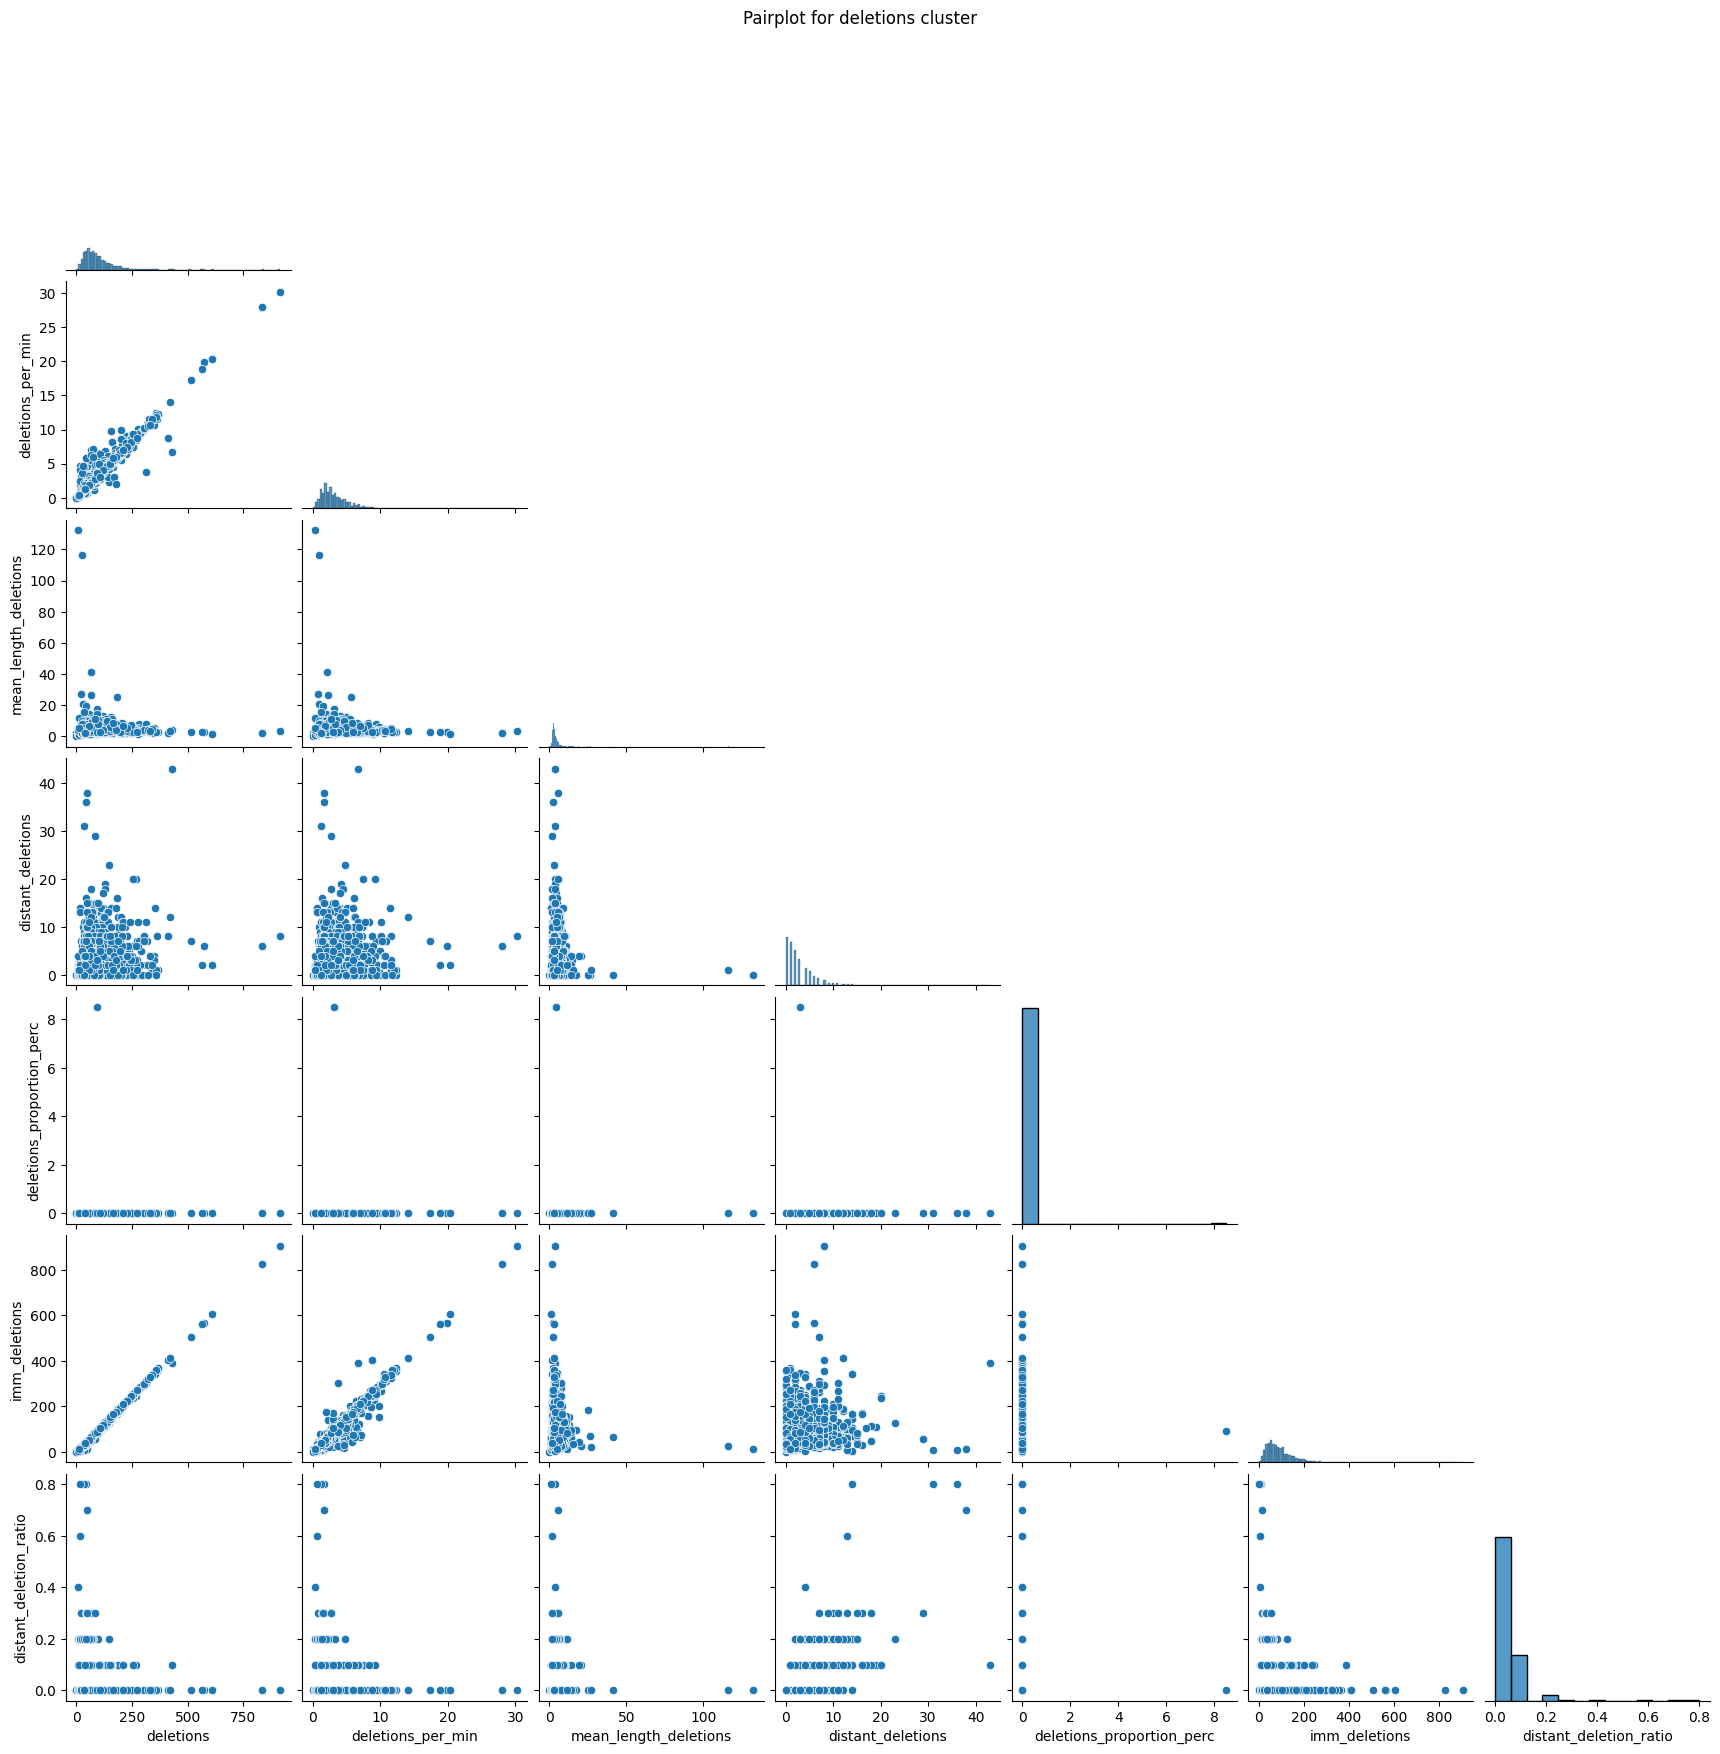

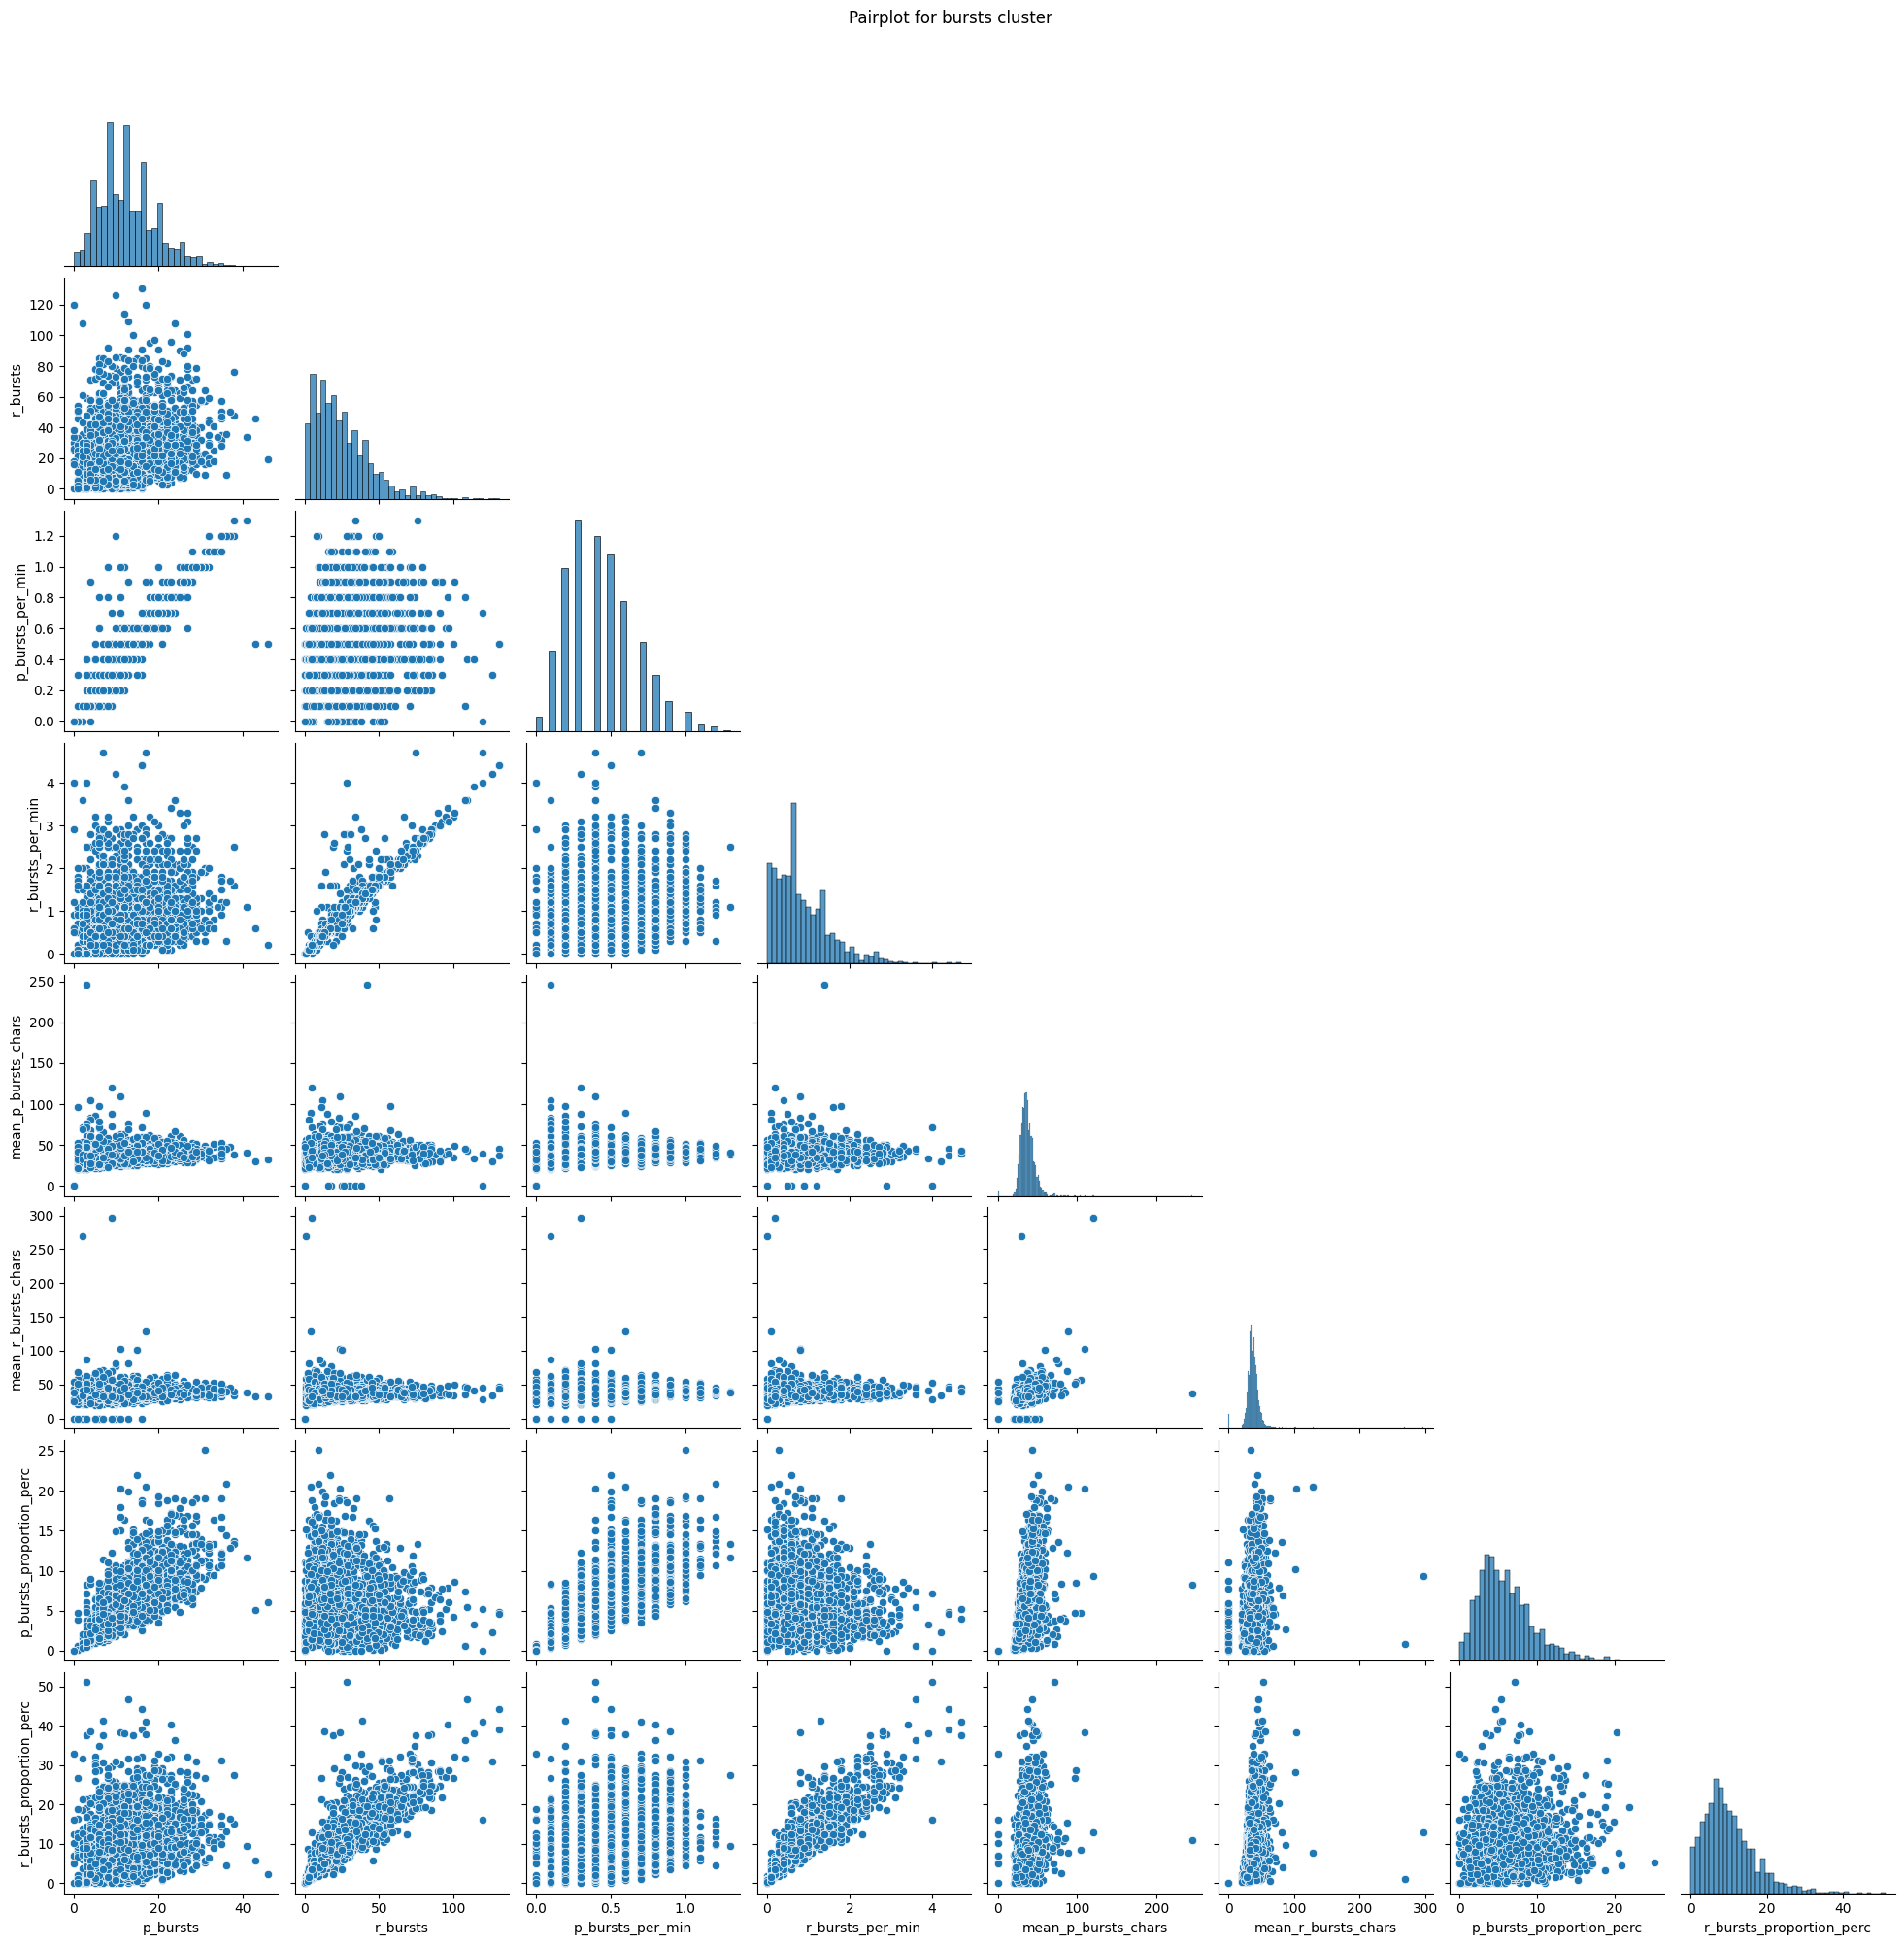

In [24]:
for i, feature_cluster in enumerate(feature_clusters):
    pair_plot = sns.pairplot(simplified_train_logs[feature_cluster], corner=True)
    pair_plot.fig.suptitle(f'Pairplot for {feature_clusters_str[i]}', y=1.005)

In [25]:
highly_correl_cols = ['chars_per_min_product', 'words_per_min_process', 'imm_deletions', 
                      'deletions_per_min', 'r_bursts_per_min']
simplified_train_logs.drop(highly_correl_cols, axis=1, inplace=True)
len(simplified_train_logs.columns)

31

In [26]:
# delete highly_correl_cols from feature_clusters
feature_clusters = [list(set(cluster) - set(highly_correl_cols)) for cluster in feature_clusters]

## Baselines 

#### Baseline with Random Forest Regressor

The challenge at hand offers two viable approaches for resolution: Classification or Regression. Given that the evaluation

metric is the root mean squared error (RMSE), our initial strategy involves approaching it as a Regression problem. To align 

with this choice, we will designate RMSE as both the metric for evaluation and the loss function where applicable.

In [27]:
# from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import make_scorer, mean_squared_error

# rf = RandomForestRegressor(random_state=SEED)

# X = simplified_train_logs
# y = train_scores.score

# num_folds = 5
# kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# # Define custom scorer for RMSE
# rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# # Perform cross-validation with RMSE as the scoring metric and obtain predictions
# cv_predictions = cross_val_predict(rf, X, y, cv=kfold)

# # Display real values, predictions, max, and min predicted values for each fold
# for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
#     predictions = cv_predictions[test_idx]

#     print(f"\nFold {fold + 1}:")
# #     print("Real Values:", y_test.values)
# #     print("Predictions:", predictions)
#     print("Max Predicted Value:", np.round(np.max(predictions),1))
#     print("Min Predicted Value:", np.round(np.min(predictions),1))

#     # Calculate and print RMSE for the fold
#     fold_rmse = np.round(np.sqrt(mean_squared_error(y_test, predictions)),2)
#     print("Fold RMSE:", fold_rmse)

# # Display the cross-validation scores
# cv_scores = cross_val_score(rf, X, y, cv=kfold, scoring=rmse_scorer)
# print("\nCross-validation RMSE scores:", -cv_scores)  # Negate scores since make_scorer uses greater_is_better=False
# print("Mean RMSE:", np.round(-cv_scores.mean(), 2))  # Negate mean as well


**Results from the previous cell** (Baseline with Random Forest Regressor):

Fold 1:
Max Predicted Value: 5.4
Min Predicted Value: 1.6
Fold RMSE: 0.61

Fold 2:
Max Predicted Value: 5.4
Min Predicted Value: 1.8
Fold RMSE: 0.73

Fold 3:
Max Predicted Value: 5.2
Min Predicted Value: 1.5
Fold RMSE: 0.68

Fold 4:
Max Predicted Value: 5.3
Min Predicted Value: 1.7
Fold RMSE: 0.71

Fold 5:
Max Predicted Value: 5.2
Min Predicted Value: 1.7
Fold RMSE: 0.66

Cross-validation RMSE scores: [0.61 0.73  0.68 0.71 0.66]


Mean RMSE: 0.68

The **submission** using this Baseline (Random Forest Regressor) achieved a score of 0.684, placing it in the top 81% of submissions.

Note that the submission score is consistent with the mean cross-validation score obtained using only the training set `train_logs`: 0.684 vs 0.68

#### Baseline with XGB Regressor

In [28]:
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor

# X = simplified_train_logs
# y = train_scores.score

# # Set the number of folds
# num_folds = 5

# # Instantiate the KFold cross-validator
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Initialize lists to store results
# max_values = []
# min_values = []
# rmse_scores = []

# regr = XGBRegressor()

# # Perform cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Initialize lists to store errors for each fold
#     train_errors_fold = []
#     test_errors_fold = []

#     # Fit the model on the training data
#     regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

#     # Get training and testing errors for each iteration of the current fold
#     train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
#     test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

#     # Make predictions on the test data
#     y_pred = regr.predict(X_test)

#     # Store max and min predicted values for each fold
#     max_values.append(np.round(np.max(y_pred), 2))
#     min_values.append(np.round(np.min(y_pred), 2))

#     # Calculate RMSE for the fold
#     rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
#     rmse_scores.append(rmse)

#     # Print results for each fold
#     print(f"\nFold {fold}: Max Predicted Value: ", np.round(np.max(y_pred), 2), "; Min Predicted Value: ", np.round(np.min(y_pred), 2), f"; Fold RMSE: {rmse}")

#     # Plot training and testing errors for the current fold
#     fig, ax = plt.subplots(figsize=(5, 3))
#     ax.plot(train_errors_fold, label='Train')
#     ax.plot(test_errors_fold, label='Test')
#     ax.set_xlabel('Number of Iterations')
#     ax.set_ylabel('RMSE')
#     ax.legend()
#     plt.title(f'Fold {fold}: Training and Testing Errors vs Number of Iterations')
#     plt.show()

# # Print average RMSE across all folds
# print(f"\nCross-validation RMSE scores: {rmse_scores}")
# print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


**Results from the previous cell** (Baseline with XGBoost Regressor):

Fold 1: Max Predicted Value:  5.55 ; Min Predicted Value:  1.04 ; Fold RMSE: 0.73

Fold 2: Max Predicted Value:  5.7 ; Min Predicted Value:  1.5 ; Fold RMSE: 0.73

Fold 3: Max Predicted Value:  5.76 ; Min Predicted Value:  1.32 ; Fold RMSE: 0.7

Fold 4: Max Predicted Value:  5.66 ; Min Predicted Value:  1.46 ; Fold RMSE: 0.72

Fold 5: Max Predicted Value:  5.67 ; Min Predicted Value:  1.36 ; Fold RMSE: 0.76

Cross-validation RMSE scores: [0.73, 0.73, 0.7, 0.72, 0.76]

Mean RMSE: 0.73

The **submission** using this Baseline (XGBoost Regressor) achieved a score of 0.72, worse than the Baseline with Random Forest.

Once again, the submission score is consistent with the mean cross-validation score: 0.72 vs 0.73

It's important to note that, during the preparation for submission, predictions have been constrained to align with the 

nearest potential target value. This restriction will remain in place for future experiments.

## More experiments with XGB Regressor

Moving forward, experiment validation will hinge on their cross-validation RMSE scores. Those that demonstrate improved

efficiency without compromising the overall outcome will be integrated into the training harness, as well.

### Feature selection

We employ two distinct methods to assess the significance of features in our dataset: XGBoost's Feature Importance and sklearn's Permutation Importance. 

Of the two methods, we prioritize the latter for its robust evaluation of feature importance through the permutation of data, providing a more comprehensive and reliable measure.

We will obtain them after training the baseline XGB Regressor model on the whole dataset. Afterwards, we will analyze each cluster of features to assess which 

features may be irrelevant. The process will be repeated after deleting them, as long as the model's performance does not deteriorate.

#### 1st iteration

In [29]:
from xgboost import XGBRegressor

X = simplified_train_logs
y = train_scores.score

regr = XGBRegressor()

# Fit the model on the whole dataset
regr.fit(X, y);

In [30]:
# Generating feature importances to be analyzed later
xgb_feature_importance_dict = dict(zip(X.columns, regr.feature_importances_))
xgb_feature_importance = {key: round(value, 2) for key, value in xgb_feature_importance_dict.items()}
xgb_feature_importance = dict(sorted(xgb_feature_importance.items(), key=lambda x: x[1], reverse=True))

from sklearn.inspection import permutation_importance
result = permutation_importance(regr, X, y, n_repeats=5, random_state=SEED)
result = dict(zip(X.columns, result.importances_mean))
result = {key: round(value, 2) for key, value in result.items()}
permutation_importances = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))

In [31]:
{key: value for key, value in xgb_feature_importance.items() if key in production_cluster}

{'words_per_min_product': 0.39,
 'num_events': 0.05,
 'chars_per_min_process': 0.04,
 'paragraphs_per_min_process': 0.04,
 'sentences_per_min_product': 0.03,
 'total_action_time_mins': 0.02,
 'sentences_per_min_process': 0.02,
 'product_process_ratio': 0.02,
 'std_chars_interval': 0.02,
 'total_time_mins': 0.01,
 'mean_action_time_ms': 0.01,
 'num_control_key': 0.01}

In [32]:
{key: value for key, value in permutation_importances.items() if key in production_cluster}

{'words_per_min_product': 0.35,
 'num_events': 0.25,
 'chars_per_min_process': 0.1,
 'sentences_per_min_product': 0.05,
 'total_action_time_mins': 0.04,
 'paragraphs_per_min_process': 0.04,
 'total_time_mins': 0.03,
 'std_chars_interval': 0.03,
 'mean_action_time_ms': 0.02,
 'sentences_per_min_process': 0.02,
 'product_process_ratio': 0.01,
 'num_control_key': 0.0}

Conclusions for production cluster: - The significance of 'num_control_key', 'product_process_ratio' and 

'sentences_per_min_process' is marginal in both instances and will be removed.

In [33]:
{key: value for key, value in xgb_feature_importance.items() if key in pause_cluster}

{'pause_time_proportion_perc': 0.03,
 'mean_pause_length_w_in_words': 0.03,
 'mean_pause_length': 0.02,
 'mean_pause_length_btw_paragraphs': 0.02,
 'mean_pause_length_btw_words': 0.02,
 'pauses_per_min': 0.01,
 'mean_pause_length_btw_sentences': 0.01}

In [34]:
{key: value for key, value in permutation_importances.items() if key in pause_cluster}

{'pause_time_proportion_perc': 0.04,
 'mean_pause_length_w_in_words': 0.04,
 'mean_pause_length_btw_sentences': 0.03,
 'mean_pause_length_btw_words': 0.03,
 'pauses_per_min': 0.02,
 'mean_pause_length': 0.02,
 'mean_pause_length_btw_paragraphs': 0.02}

Conclusions for pause cluster: Both methods attribute slight importance to this group of features. 

'mean_pause_length_btw_paragraphs' will be the first one to go.

In [35]:
{key: value for key, value in xgb_feature_importance.items() if key in deletions_cluster}

{'mean_length_deletions': 0.02,
 'deletions': 0.01,
 'distant_deletions': 0.01,
 'distant_deletion_ratio': 0.01,
 'deletions_proportion_perc': 0.0}

In [36]:
{key: value for key, value in permutation_importances.items() if key in deletions_cluster}

{'deletions': 0.05,
 'mean_length_deletions': 0.03,
 'distant_deletions': 0.01,
 'deletions_proportion_perc': 0.0,
 'distant_deletion_ratio': 0.0}

Conclusions for deletions cluster: 'deletions_proportion_perc' shows a null value in both cases. To be deleted

In [37]:
{key: value for key, value in xgb_feature_importance.items() if key in bursts_cluster}

{'p_bursts': 0.04,
 'p_bursts_per_min': 0.03,
 'r_bursts': 0.02,
 'p_bursts_proportion_perc': 0.02,
 'r_bursts_proportion_perc': 0.02,
 'mean_p_bursts_chars': 0.01,
 'mean_r_bursts_chars': 0.01}

In [38]:
{key: value for key, value in permutation_importances.items() if key in bursts_cluster}

{'p_bursts': 0.06,
 'r_bursts': 0.03,
 'mean_r_bursts_chars': 0.03,
 'p_bursts_proportion_perc': 0.03,
 'mean_p_bursts_chars': 0.02,
 'r_bursts_proportion_perc': 0.02,
 'p_bursts_per_min': 0.0}

Conclusions for bursts cluster: Since 'p_bursts_per_min' is useless according to Permutation Importance, it will be eliminated in the next iteration.

#### 2nd iteration

In [39]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

X = simplified_train_logs[['num_events', 'total_time_mins', 'total_action_time_mins',
       'mean_action_time_ms', 'chars_per_min_process', 'words_per_min_product',
       'sentences_per_min_product',
       'paragraphs_per_min_process', 'pauses_per_min',
       'pause_time_proportion_perc', 'mean_pause_length',
       'mean_pause_length_btw_sentences',
       'mean_pause_length_btw_words', 'mean_pause_length_w_in_words',
       'deletions', 'mean_length_deletions', 'distant_deletions',
       'distant_deletion_ratio',
       'p_bursts', 'r_bursts',
       'mean_p_bursts_chars', 'mean_r_bursts_chars',
       'p_bursts_proportion_perc', 'r_bursts_proportion_perc',
       'std_chars_interval']]

y = train_scores.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Initialize lists to store results
rmse_scores = []

regr = XGBRegressor()

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

    # Get training and testing errors for each iteration of the current fold
    train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
    test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

    # Make predictions on the test data
    y_pred = regr.predict(X_test)

    # Calculate RMSE for the fold
    rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
    rmse_scores.append(rmse)

# Print average RMSE across all folds
print(f"\nCross-validation RMSE scores: {rmse_scores}")
print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


Cross-validation RMSE scores: [0.74, 0.73, 0.7, 0.72, 0.78]

Mean RMSE: 0.73


After eliminating 7 features the performance of the model stays the same: Mean RMSE = 0.73

In [40]:
regr.fit(X,y);

In [41]:
# Generating feature importances to be analyzed later
xgb_feature_importance_dict = dict(zip(X.columns, regr.feature_importances_))
xgb_feature_importance = {key: round(value, 2) for key, value in xgb_feature_importance_dict.items()}
xgb_feature_importance = dict(sorted(xgb_feature_importance.items(), key=lambda x: x[1], reverse=True))

from sklearn.inspection import permutation_importance
result = permutation_importance(regr, X, y, n_repeats=5, random_state=SEED)
result = dict(zip(X.columns, result.importances_mean))
result = {key: round(value, 2) for key, value in result.items()}
permutation_importances = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))

In [42]:
{key: value for key, value in xgb_feature_importance.items() if key in production_cluster}

{'words_per_min_product': 0.39,
 'num_events': 0.06,
 'chars_per_min_process': 0.04,
 'sentences_per_min_product': 0.04,
 'paragraphs_per_min_process': 0.04,
 'total_action_time_mins': 0.02,
 'total_time_mins': 0.01,
 'mean_action_time_ms': 0.01,
 'std_chars_interval': 0.01}

In [43]:
{key: value for key, value in permutation_importances.items() if key in production_cluster}

{'words_per_min_product': 0.47,
 'num_events': 0.2,
 'chars_per_min_process': 0.09,
 'sentences_per_min_product': 0.08,
 'total_action_time_mins': 0.06,
 'paragraphs_per_min_process': 0.05,
 'total_time_mins': 0.03,
 'std_chars_interval': 0.03,
 'mean_action_time_ms': 0.02}

In [44]:
{key: value for key, value in xgb_feature_importance.items() if key in pause_cluster}

{'pause_time_proportion_perc': 0.03,
 'mean_pause_length_w_in_words': 0.03,
 'mean_pause_length': 0.02,
 'mean_pause_length_btw_sentences': 0.02,
 'mean_pause_length_btw_words': 0.02,
 'pauses_per_min': 0.01}

In [45]:
{key: value for key, value in permutation_importances.items() if key in pause_cluster}

{'pause_time_proportion_perc': 0.05,
 'mean_pause_length_w_in_words': 0.05,
 'mean_pause_length': 0.03,
 'mean_pause_length_btw_sentences': 0.03,
 'mean_pause_length_btw_words': 0.03,
 'pauses_per_min': 0.02}

In [46]:
{key: value for key, value in xgb_feature_importance.items() if key in deletions_cluster}

{'distant_deletion_ratio': 0.03,
 'deletions': 0.02,
 'mean_length_deletions': 0.02,
 'distant_deletions': 0.01}

In [47]:
{key: value for key, value in permutation_importances.items() if key in deletions_cluster}

{'deletions': 0.05,
 'mean_length_deletions': 0.03,
 'distant_deletions': 0.01,
 'distant_deletion_ratio': 0.0}

In [48]:
{key: value for key, value in xgb_feature_importance.items() if key in bursts_cluster}

{'p_bursts': 0.04,
 'p_bursts_proportion_perc': 0.03,
 'r_bursts': 0.02,
 'mean_p_bursts_chars': 0.02,
 'mean_r_bursts_chars': 0.02,
 'r_bursts_proportion_perc': 0.02}

In [49]:
{key: value for key, value in permutation_importances.items() if key in bursts_cluster}

{'p_bursts': 0.05,
 'r_bursts': 0.04,
 'p_bursts_proportion_perc': 0.04,
 'mean_r_bursts_chars': 0.03,
 'mean_p_bursts_chars': 0.02,
 'r_bursts_proportion_perc': 0.02}

Conclusions : Next candidates for deletion, in order: 'distant_deletion_ratio', 'mean_pause_length_btw_words', 

'r_bursts_proportion_perc', 'mean_action_time_ms', 'std_chars_interval' ,'total_time_mins', 'paragraphs_per_min_process'.

#### 3rd iteration

In [50]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

X = simplified_train_logs[['num_events', 'total_action_time_mins',
       'chars_per_min_process', 'words_per_min_product',
       'sentences_per_min_product',
       'pauses_per_min',
       'pause_time_proportion_perc', 'mean_pause_length',
       'mean_pause_length_btw_sentences',
       'mean_pause_length_w_in_words',
       'deletions', 'mean_length_deletions', 'distant_deletions',
       'p_bursts', 'r_bursts',
       'mean_p_bursts_chars', 'mean_r_bursts_chars',
       'p_bursts_proportion_perc']]

y = train_scores.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Initialize lists to store results
rmse_scores = []

regr = XGBRegressor()

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

    # Get training and testing errors for each iteration of the current fold
    train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
    test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

    # Make predictions on the test data
    y_pred = regr.predict(X_test)

    # Calculate RMSE for the fold
    rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
    rmse_scores.append(rmse)

# Print average RMSE across all folds
print(f"\nCross-validation RMSE scores: {rmse_scores}")
print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


Cross-validation RMSE scores: [0.72, 0.72, 0.7, 0.76, 0.76]

Mean RMSE: 0.73


After deleting the aforementioned 7 features, performance continues at 0.73.

In [51]:
regr.fit(X,y);

In [52]:
# Generating feature importances to be analyzed later
xgb_feature_importance_dict = dict(zip(X.columns, regr.feature_importances_))
xgb_feature_importance = {key: round(value, 2) for key, value in xgb_feature_importance_dict.items()}
xgb_feature_importance = dict(sorted(xgb_feature_importance.items(), key=lambda x: x[1], reverse=True))

from sklearn.inspection import permutation_importance
result = permutation_importance(regr, X, y, n_repeats=5, random_state=SEED)
result = dict(zip(X.columns, result.importances_mean))
result = {key: round(value, 2) for key, value in result.items()}
permutation_importances = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))

In [53]:
{key: value for key, value in xgb_feature_importance.items() if key in production_cluster}

{'words_per_min_product': 0.43,
 'num_events': 0.08,
 'chars_per_min_process': 0.05,
 'sentences_per_min_product': 0.04,
 'total_action_time_mins': 0.02}

In [54]:
{key: value for key, value in permutation_importances.items() if key in production_cluster}

{'words_per_min_product': 0.4,
 'num_events': 0.33,
 'chars_per_min_process': 0.13,
 'sentences_per_min_product': 0.09,
 'total_action_time_mins': 0.06}

In [55]:
{key: value for key, value in xgb_feature_importance.items() if key in pause_cluster}

{'pause_time_proportion_perc': 0.04,
 'mean_pause_length_w_in_words': 0.04,
 'mean_pause_length': 0.03,
 'mean_pause_length_btw_sentences': 0.03,
 'pauses_per_min': 0.02}

In [56]:
{key: value for key, value in permutation_importances.items() if key in pause_cluster}

{'pause_time_proportion_perc': 0.07,
 'mean_pause_length_w_in_words': 0.07,
 'pauses_per_min': 0.05,
 'mean_pause_length_btw_sentences': 0.05,
 'mean_pause_length': 0.03}

In [57]:
{key: value for key, value in xgb_feature_importance.items() if key in deletions_cluster}

{'deletions': 0.03, 'mean_length_deletions': 0.03, 'distant_deletions': 0.02}

In [58]:
{key: value for key, value in permutation_importances.items() if key in deletions_cluster}

{'deletions': 0.06, 'mean_length_deletions': 0.05, 'distant_deletions': 0.02}

In [59]:
{key: value for key, value in xgb_feature_importance.items() if key in bursts_cluster}

{'p_bursts': 0.05,
 'mean_r_bursts_chars': 0.03,
 'p_bursts_proportion_perc': 0.03,
 'r_bursts': 0.02,
 'mean_p_bursts_chars': 0.02}

In [60]:
{key: value for key, value in permutation_importances.items() if key in bursts_cluster}

{'p_bursts': 0.1,
 'r_bursts': 0.05,
 'mean_p_bursts_chars': 0.04,
 'mean_r_bursts_chars': 0.04,
 'p_bursts_proportion_perc': 0.04}

Conclusions : Next candidates for deletion, in order: 'distant_deletions', 'mean_pause_length', 'mean_p_bursts_chars'.

In addition to the criteria previously mentioned, we are now prioritizing removal of features within richer clusters. 

#### 4th iteration

In [61]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

X = simplified_train_logs[['num_events', 'total_action_time_mins',
       'chars_per_min_process', 'words_per_min_product',
       'sentences_per_min_product',
       'pauses_per_min',
       'pause_time_proportion_perc',
       'mean_pause_length_btw_sentences',
       'mean_pause_length_w_in_words',
       'deletions', 'mean_length_deletions',
       'p_bursts', 'r_bursts',
       'mean_r_bursts_chars',
       'p_bursts_proportion_perc']]

y = train_scores.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Initialize lists to store results
rmse_scores = []

regr = XGBRegressor()

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

    # Get training and testing errors for each iteration of the current fold
    train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
    test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

    # Make predictions on the test data
    y_pred = regr.predict(X_test)

    # Calculate RMSE for the fold
    rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
    rmse_scores.append(rmse)

# Print average RMSE across all folds
print(f"\nCross-validation RMSE scores: {rmse_scores}")
print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


Cross-validation RMSE scores: [0.73, 0.73, 0.7, 0.75, 0.79]

Mean RMSE: 0.74


After deleting 3 more features, the model performance drops slightly to 0.74, from 0.73. It looks like an acceptable tradeoff.

In [62]:
print(f"Now the dataset contains {len(X.columns)} features.")

Now the dataset contains 15 features.


In [63]:
regr.fit(X,y);

In [64]:
# Generating feature importances to be analyzed later
xgb_feature_importance_dict = dict(zip(X.columns, regr.feature_importances_))
xgb_feature_importance = {key: round(value, 2) for key, value in xgb_feature_importance_dict.items()}
xgb_feature_importance = dict(sorted(xgb_feature_importance.items(), key=lambda x: x[1], reverse=True))

from sklearn.inspection import permutation_importance
result = permutation_importance(regr, X, y, n_repeats=5, random_state=SEED)
result = dict(zip(X.columns, result.importances_mean))
result = {key: round(value, 2) for key, value in result.items()}
permutation_importances = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))

In [65]:
{key: value for key, value in xgb_feature_importance.items() if key in production_cluster}

{'words_per_min_product': 0.43,
 'num_events': 0.09,
 'chars_per_min_process': 0.05,
 'sentences_per_min_product': 0.05,
 'total_action_time_mins': 0.02}

In [66]:
{key: value for key, value in permutation_importances.items() if key in production_cluster}

{'words_per_min_product': 0.39,
 'num_events': 0.33,
 'chars_per_min_process': 0.14,
 'sentences_per_min_product': 0.11,
 'total_action_time_mins': 0.08}

In [67]:
{key: value for key, value in xgb_feature_importance.items() if key in pause_cluster}

{'pause_time_proportion_perc': 0.05,
 'mean_pause_length_w_in_words': 0.04,
 'pauses_per_min': 0.03,
 'mean_pause_length_btw_sentences': 0.03}

In [68]:
{key: value for key, value in permutation_importances.items() if key in pause_cluster}

{'mean_pause_length_w_in_words': 0.09,
 'pause_time_proportion_perc': 0.08,
 'mean_pause_length_btw_sentences': 0.06,
 'pauses_per_min': 0.05}

In [69]:
{key: value for key, value in xgb_feature_importance.items() if key in deletions_cluster}

{'deletions': 0.03, 'mean_length_deletions': 0.03}

In [70]:
{key: value for key, value in permutation_importances.items() if key in deletions_cluster}

{'deletions': 0.08, 'mean_length_deletions': 0.05}

In [71]:
{key: value for key, value in xgb_feature_importance.items() if key in bursts_cluster}

{'p_bursts': 0.06,
 'r_bursts': 0.03,
 'mean_r_bursts_chars': 0.03,
 'p_bursts_proportion_perc': 0.03}

In [72]:
{key: value for key, value in permutation_importances.items() if key in bursts_cluster}

{'p_bursts': 0.08,
 'p_bursts_proportion_perc': 0.06,
 'mean_r_bursts_chars': 0.05,
 'r_bursts': 0.04}

Conclusions: It will not be surprising if the model can't afford losing more features. However, the following features appear to be prime candidates for deletion 

in the next iteration: 'r_bursts', 'mean_length_deletions', 'pauses_per_min', 'total_action_time_mins'.

#### 5th iteration

In [73]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

X = simplified_train_logs[['num_events',
       'chars_per_min_process', 'words_per_min_product',
       'sentences_per_min_product',
       'pause_time_proportion_perc',
       'mean_pause_length_btw_sentences',
       'mean_pause_length_w_in_words',
       'deletions',
       'p_bursts',
       'mean_r_bursts_chars',
       'p_bursts_proportion_perc']]
y = train_scores.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Initialize lists to store results
rmse_scores = []

regr = XGBRegressor()

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

    # Get training and testing errors for each iteration of the current fold
    train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
    test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

    # Make predictions on the test data
    y_pred = regr.predict(X_test)

    # Calculate RMSE for the fold
    rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
    rmse_scores.append(rmse)

# Print average RMSE across all folds
print(f"\nCross-validation RMSE scores: {rmse_scores}")
print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


Cross-validation RMSE scores: [0.72, 0.72, 0.69, 0.75, 0.77]

Mean RMSE: 0.73


The model score goes back to a Mean RMSE of 0.73 after deleting 4 more features. 

In [74]:
print(f"Now the dataset contains {len(X.columns)} features.")

Now the dataset contains 11 features.


In [75]:
regr.fit(X,y);

In [76]:
# Generating feature importances to be analyzed later
xgb_feature_importance_dict = dict(zip(X.columns, regr.feature_importances_))
xgb_feature_importance = {key: round(value, 2) for key, value in xgb_feature_importance_dict.items()}
xgb_feature_importance = dict(sorted(xgb_feature_importance.items(), key=lambda x: x[1], reverse=True))

from sklearn.inspection import permutation_importance
result = permutation_importance(regr, X, y, n_repeats=5, random_state=SEED)
result = dict(zip(X.columns, result.importances_mean))
result = {key: round(value, 2) for key, value in result.items()}
permutation_importances = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))

In [77]:
{key: value for key, value in xgb_feature_importance.items() if key in production_cluster}

{'words_per_min_product': 0.46,
 'num_events': 0.1,
 'chars_per_min_process': 0.06,
 'sentences_per_min_product': 0.06}

In [78]:
{key: value for key, value in permutation_importances.items() if key in production_cluster}

{'words_per_min_product': 0.49,
 'num_events': 0.48,
 'chars_per_min_process': 0.19,
 'sentences_per_min_product': 0.14}

In [79]:
{key: value for key, value in xgb_feature_importance.items() if key in pause_cluster}

{'pause_time_proportion_perc': 0.06,
 'mean_pause_length_w_in_words': 0.05,
 'mean_pause_length_btw_sentences': 0.04}

In [80]:
{key: value for key, value in permutation_importances.items() if key in pause_cluster}

{'pause_time_proportion_perc': 0.12,
 'mean_pause_length_w_in_words': 0.12,
 'mean_pause_length_btw_sentences': 0.07}

In [81]:
{key: value for key, value in xgb_feature_importance.items() if key in deletions_cluster}

{'deletions': 0.04}

In [82]:
{key: value for key, value in permutation_importances.items() if key in deletions_cluster}

{'deletions': 0.09}

In [83]:
{key: value for key, value in xgb_feature_importance.items() if key in bursts_cluster}

{'p_bursts': 0.06,
 'mean_r_bursts_chars': 0.04,
 'p_bursts_proportion_perc': 0.04}

In [84]:
{key: value for key, value in permutation_importances.items() if key in bursts_cluster}

{'p_bursts': 0.1,
 'p_bursts_proportion_perc': 0.08,
 'mean_r_bursts_chars': 0.07}

Conclusions: Next variables to potentially dispense with: 'mean_pause_length_btw_sentences', 'mean_r_bursts_chars', 'deletions', 'p_bursts_proportion_perc'.

#### 6th iteration

In [85]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

X = simplified_train_logs[['num_events',
       'chars_per_min_process', 'words_per_min_product',
       'sentences_per_min_product',
       'pause_time_proportion_perc',
       'mean_pause_length_w_in_words',
       'p_bursts']]

y = train_scores.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Initialize lists to store results
rmse_scores = []

regr = XGBRegressor()

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

    # Get training and testing errors for each iteration of the current fold
    train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
    test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

    # Make predictions on the test data
    y_pred = regr.predict(X_test)

    # Calculate RMSE for the fold
    rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
    rmse_scores.append(rmse)

# Print average RMSE across all folds
print(f"\nCross-validation RMSE scores: {rmse_scores}")
print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


Cross-validation RMSE scores: [0.73, 0.75, 0.68, 0.76, 0.8]

Mean RMSE: 0.74


The model remains stable at Mean RMSE 0.74 after dismissing 4 new features

In [86]:
print(f"Now the dataset contains {len(X.columns)} features.")

Now the dataset contains 7 features.


In [87]:
regr.fit(X,y);

In [88]:
# Generating feature importances to be analyzed later
xgb_feature_importance_dict = dict(zip(X.columns, regr.feature_importances_))
xgb_feature_importance = {key: round(value, 2) for key, value in xgb_feature_importance_dict.items()}
xgb_feature_importance = dict(sorted(xgb_feature_importance.items(), key=lambda x: x[1], reverse=True))

from sklearn.inspection import permutation_importance
result = permutation_importance(regr, X, y, n_repeats=5, random_state=SEED)
result = dict(zip(X.columns, result.importances_mean))
result = {key: round(value, 2) for key, value in result.items()}
permutation_importances = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))

In [89]:
{key: value for key, value in xgb_feature_importance.items() if key in production_cluster}

{'words_per_min_product': 0.46,
 'num_events': 0.14,
 'sentences_per_min_product': 0.08,
 'chars_per_min_process': 0.07}

In [90]:
{key: value for key, value in permutation_importances.items() if key in production_cluster}

{'num_events': 0.72,
 'words_per_min_product': 0.55,
 'chars_per_min_process': 0.42,
 'sentences_per_min_product': 0.18}

In [91]:
{key: value for key, value in xgb_feature_importance.items() if key in pause_cluster}

{'pause_time_proportion_perc': 0.09, 'mean_pause_length_w_in_words': 0.08}

In [92]:
{key: value for key, value in permutation_importances.items() if key in pause_cluster}

{'pause_time_proportion_perc': 0.19, 'mean_pause_length_w_in_words': 0.16}

In [93]:
{key: value for key, value in xgb_feature_importance.items() if key in deletions_cluster}

{}

In [94]:
{key: value for key, value in permutation_importances.items() if key in deletions_cluster}

{}

In [95]:
{key: value for key, value in xgb_feature_importance.items() if key in bursts_cluster}

{'p_bursts': 0.08}

In [96]:
{key: value for key, value in permutation_importances.items() if key in bursts_cluster}

{'p_bursts': 0.13}

Conclusions: Probably not possible to delete more features without affecting the model performance significantly. We will try with 'p_bursts', 'mean_pause_length_w_in_words', 'sentences_per_min_product' and 'chars_per_min_process'.

#### 7th iteration

In [97]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

X = simplified_train_logs[['num_events',
                           'chars_per_min_process', 
                           'words_per_min_product',
                           'sentences_per_min_product',
                           'pause_time_proportion_perc',
                           'mean_pause_length_w_in_words']]

y = train_scores.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Initialize lists to store results
rmse_scores = []

regr = XGBRegressor()

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

    # Get training and testing errors for each iteration of the current fold
    train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
    test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

    # Make predictions on the test data
    y_pred = regr.predict(X_test)

    # Calculate RMSE for the fold
    rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
    rmse_scores.append(rmse)

# Print average RMSE across all folds
print(f"\nCross-validation RMSE scores: {rmse_scores}")
print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


Cross-validation RMSE scores: [0.75, 0.73, 0.67, 0.76, 0.8]

Mean RMSE: 0.74


It was possible to eliminate one of the features while maintaining a 0.74. Here concludes the process.

In [98]:
print(f"Now the dataset contains these {len(X.columns)} features:\n\n {X.columns}")

Now the dataset contains these 6 features:

 Index(['num_events', 'chars_per_min_process', 'words_per_min_product',
       'sentences_per_min_product', 'pause_time_proportion_perc',
       'mean_pause_length_w_in_words'],
      dtype='object')


Now we'll execute the Random Forest Baseline Model with this new set of features

In [99]:
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error

rf = RandomForestRegressor(random_state=SEED)

X = simplified_train_logs[['num_events', 'chars_per_min_process', 'words_per_min_product',
       'sentences_per_min_product', 'pause_time_proportion_perc',
       'mean_pause_length_w_in_words']]

y = train_scores.score

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define custom scorer for RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
 
cv_scores = cross_val_score(rf, X, y, cv=kfold, scoring=rmse_scorer)
print("\nCross-validation RMSE scores:", -cv_scores)  # Negate scores since make_scorer uses greater_is_better=False
print("Mean RMSE:", np.round(-cv_scores.mean(), 2))  # Negate mean as well



Cross-validation RMSE scores: [0.63291709 0.74420219 0.70541852 0.72191764 0.6749874 ]
Mean RMSE: 0.7


The Random Forest Baseline Model shows now a Mean RMSE of 0.7, slighly worse than the initial 0.68. Again, it seems a reasonable tradeoff.

In the future, we will exclude the Random Forest algorithm from consideration, as XGBoost is expected to outperform it in effectively addressing this challenge.

### Adding feature with Kmeans

Now the KMeans algorithm will be performed on the whole dataset in order to estimate a suitable number of clusters.

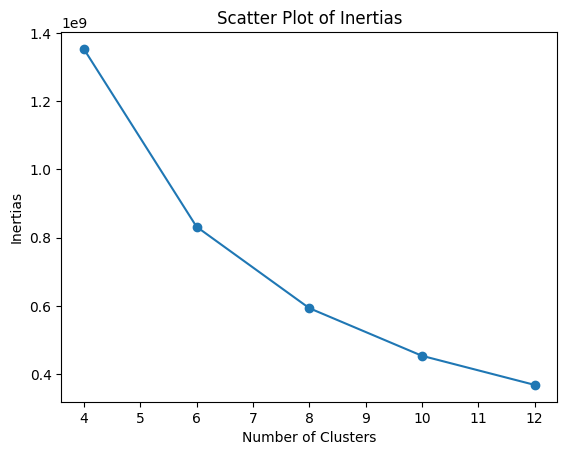

In [100]:
from sklearn.cluster import KMeans
inertias = {}
for n_clusters in [4, 6, 8, 10, 12]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED).fit(simplified_train_logs[[
        'num_events', 'chars_per_min_process', 'words_per_min_product',
        'sentences_per_min_product', 'pause_time_proportion_perc',
        'mean_pause_length_w_in_words']]
)
    inertias[n_clusters] = kmeans.inertia_

num_clusters = list(inertias.keys())
inertias = list(inertias.values())

plt.plot(num_clusters, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertias')
plt.title('Scatter Plot of Inertias');

The chosen value for number of clusters will be 6, since there is a remarkable change in slope beyond this point. 


Value Counts for kmeans labels in the Train Set of the current fold:

 kmeans
3    588
0    561
4    374
1    223
2    161
5     69
Name: count, dtype: int64

Value Counts for kmeans labels in the Test Set of the current fold:

 kmeans
3    150
0    116
4    110
1     53
2     44
5     22
Name: count, dtype: int64

Fold 1: Max Predicted Value:  5.76 ; Min Predicted Value:  0.93 ; Fold RMSE: 0.74


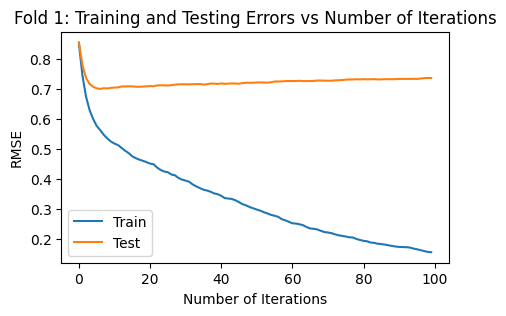


Value Counts for kmeans labels in the Train Set of the current fold:

 kmeans
1    577
2    546
0    406
5    211
3    172
4     65
Name: count, dtype: int64

Value Counts for kmeans labels in the Test Set of the current fold:

 kmeans
2    145
1    137
0     82
5     67
3     39
4     24
Name: count, dtype: int64

Fold 2: Max Predicted Value:  5.74 ; Min Predicted Value:  1.26 ; Fold RMSE: 0.76


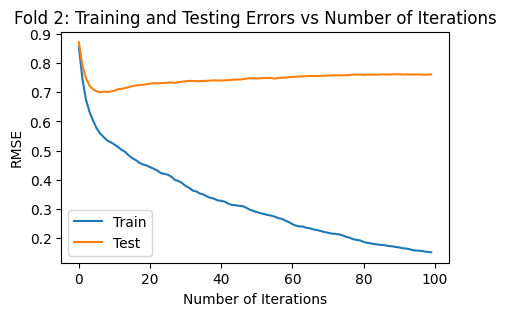


Value Counts for kmeans labels in the Train Set of the current fold:

 kmeans
0    599
2    525
1    389
5    218
4    171
3     75
Name: count, dtype: int64

Value Counts for kmeans labels in the Test Set of the current fold:

 kmeans
0    151
2    141
1     89
5     56
4     39
3     18
Name: count, dtype: int64

Fold 3: Max Predicted Value:  5.35 ; Min Predicted Value:  1.43 ; Fold RMSE: 0.67


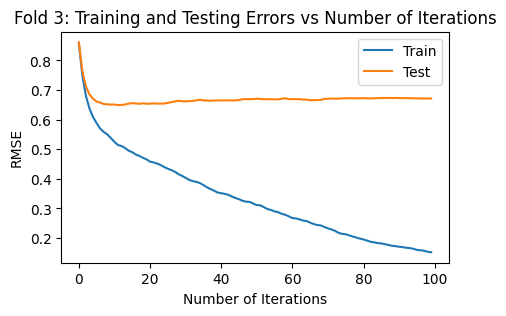


Value Counts for kmeans labels in the Train Set of the current fold:

 kmeans
1    584
5    561
2    392
0    225
4    146
3     69
Name: count, dtype: int64

Value Counts for kmeans labels in the Test Set of the current fold:

 kmeans
1    166
5    136
2    101
0     45
4     31
3     15
Name: count, dtype: int64

Fold 4: Max Predicted Value:  5.74 ; Min Predicted Value:  1.13 ; Fold RMSE: 0.76


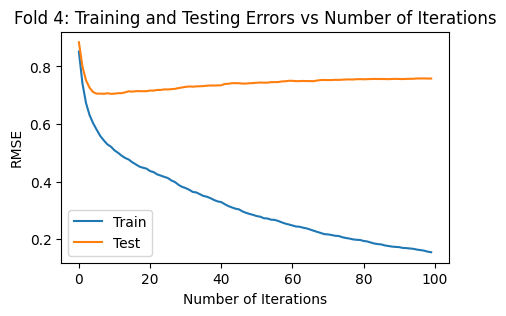


Value Counts for kmeans labels in the Train Set of the current fold:

 kmeans
0    612
3    542
1    382
2    225
5    138
4     78
Name: count, dtype: int64

Value Counts for kmeans labels in the Test Set of the current fold:

 kmeans
3    149
0    138
1    104
2     51
5     39
4     13
Name: count, dtype: int64

Fold 5: Max Predicted Value:  5.72 ; Min Predicted Value:  1.35 ; Fold RMSE: 0.79


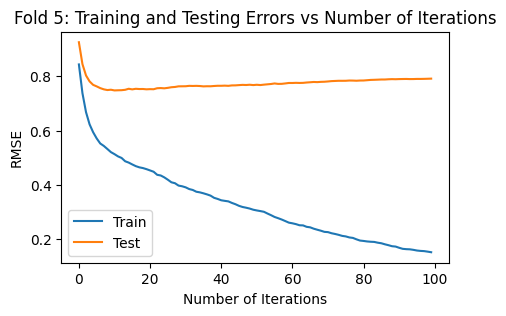


Cross-validation RMSE scores: [0.74, 0.76, 0.67, 0.76, 0.79]

Mean RMSE: 0.74


In [101]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor


simplified_train_logs['kmeans'] = 0

X = simplified_train_logs[['num_events', 'chars_per_min_process', 'words_per_min_product',
                           'sentences_per_min_product', 'pause_time_proportion_perc',
                           'mean_pause_length_w_in_words', 'kmeans']]

y = train_scores.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Initialize lists to store results
max_values = []
min_values = []
rmse_scores = []

regr = XGBRegressor()

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=6, random_state=SEED).fit(X_train.drop('kmeans', axis=1))
    X_train['kmeans'] = kmeans.labels_
    X_test['kmeans'] = kmeans.predict(X_test.drop('kmeans', axis=1))

    print("\nValue Counts for kmeans labels in the Train Set of the current fold:\n\n", X_train.kmeans.value_counts())
    print("\nValue Counts for kmeans labels in the Test Set of the current fold:\n\n", X_test.kmeans.value_counts())

    # Initialize lists to store errors for each fold
    train_errors_fold = []
    test_errors_fold = []

    # Fit the model on the training data
    regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
    # Get training and testing errors for each iteration of the current fold
    train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
    test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

    # Make predictions on the test data
    y_pred = regr.predict(X_test)

    # Store max and min predicted values for each fold
    max_values.append(np.round(np.max(y_pred), 2))
    min_values.append(np.round(np.min(y_pred), 2))

    # Calculate RMSE for the fold
    rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
    rmse_scores.append(rmse)

    # Print results for each fold
    print(f"\nFold {fold}: Max Predicted Value: ", np.round(np.max(y_pred), 2), "; Min Predicted Value: ", np.round(np.min(y_pred), 2), f"; Fold RMSE: {rmse}")

    # Plot training and testing errors for the current fold
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(train_errors_fold, label='Train')
    ax.plot(test_errors_fold, label='Test')
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('RMSE')
    ax.legend()
    plt.title(f'Fold {fold}: Training and Testing Errors vs Number of Iterations')
    plt.show()

# Print average RMSE across all folds
print(f"\nCross-validation RMSE scores: {rmse_scores}")
print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


On the one hand, the performance of the model does not improve: stays in 0.74. On the other hand, the variance of the cross-validation 

scores reduces marginally, not enough to approve the experiment, though. Therefore, the KMeans feature is dismissed.

### Adding PCA (Principal Component Analysis) components (features)

Much like our previous approach with KMeans, we will now determine the optimal number of PCA 

components to effectively capture the essence of the dataset, ensuring minimal loss of information.


	- PCA with 2 components:

                           Comp1     Comp2
Proportion of Variance  0.657378  0.153081

 2 components account for 81.05% of the variance.

	- PCA with 3 components:

                           Comp1     Comp2     Comp3
Proportion of Variance  0.657378  0.153081  0.077624

 3 components account for 88.81% of the variance.

	- PCA with 4 components:

                           Comp1     Comp2     Comp3     Comp4
Proportion of Variance  0.657378  0.153081  0.077624  0.061486

 4 components account for 94.96% of the variance.

	- PCA with 5 components:

                           Comp1     Comp2     Comp3     Comp4     Comp5
Proportion of Variance  0.657378  0.153081  0.077624  0.061486  0.038678

 5 components account for 98.82% of the variance.




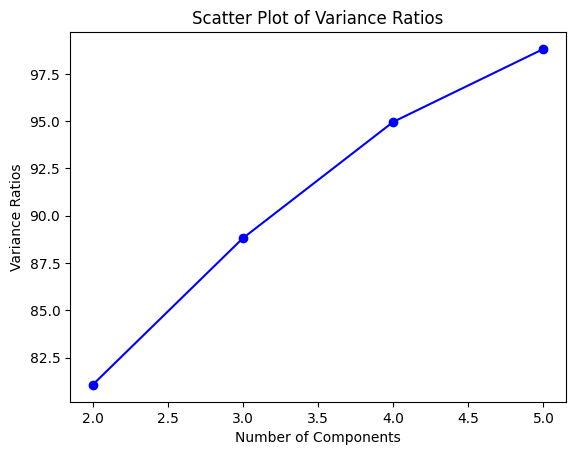

In [102]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
simplified_train_logs_scaled = scaler.fit_transform(simplified_train_logs[[
    'num_events', 'chars_per_min_process', 'words_per_min_product',
    'sentences_per_min_product', 'pause_time_proportion_perc',
    'mean_pause_length_w_in_words']])

# Loop over the number of PCA components
var_ratios = {}
for n_components in [2, 3, 4, 5]:
    print(f'\n\t- PCA with {n_components} components:\n')
    
    # Perform PCA
    logs_pca = PCA(n_components=n_components, random_state=SEED)
    logs_pca.fit(simplified_train_logs_scaled)
    
    # Variance ratio
    var_ratio = logs_pca.explained_variance_ratio_
    var_ratio = pd.DataFrame(var_ratio).transpose()
    var_ratio.columns = [f'Comp{i}' for i in range(1, n_components + 1)]
    var_ratio.index = ['Proportion of Variance']
    print(var_ratio)
    
    print('\n', 
          f'{n_components} components account for',
          f'{np.round(var_ratio.sum().sum() * 100, 2)}% of the variance.')
    
    var_ratios[n_components] = np.round(var_ratio.sum().sum() * 100, 2)

print('\n')
keys = list(var_ratios.keys())
values = list(var_ratios.values())

plt.plot(keys, values, color='blue', marker='o', label='Variance Ratios')
plt.xlabel('Number of Components')
plt.ylabel('Variance Ratios')
plt.title('Scatter Plot of Variance Ratios');

We will conduct experiments using both 3 and 4 PCA components, since 4 already cover 95% of the variance.

#### Adding 3 PCA Components


Fold 1: Max Predicted Value:  5.76 ; Min Predicted Value:  0.86 ; Fold RMSE: 0.74


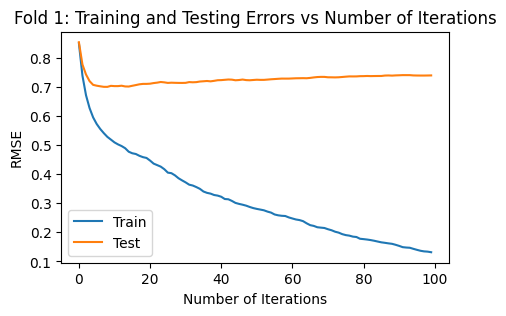


Fold 2: Max Predicted Value:  5.98 ; Min Predicted Value:  1.49 ; Fold RMSE: 0.75


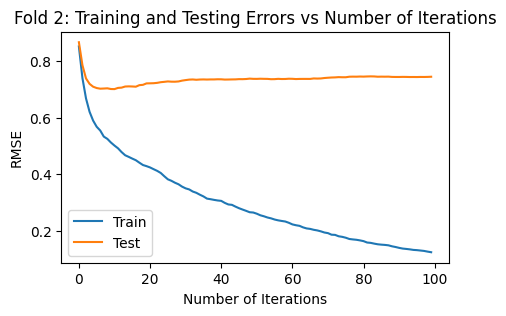


Fold 3: Max Predicted Value:  5.66 ; Min Predicted Value:  1.16 ; Fold RMSE: 0.71


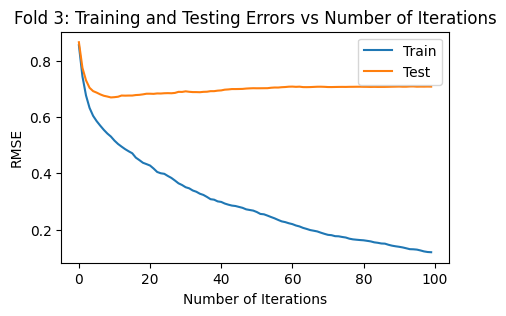


Fold 4: Max Predicted Value:  5.91 ; Min Predicted Value:  1.01 ; Fold RMSE: 0.77


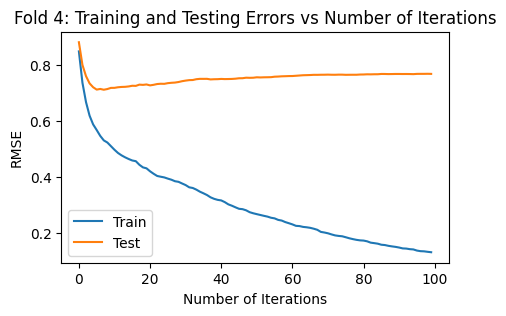


Fold 5: Max Predicted Value:  5.92 ; Min Predicted Value:  1.5 ; Fold RMSE: 0.79


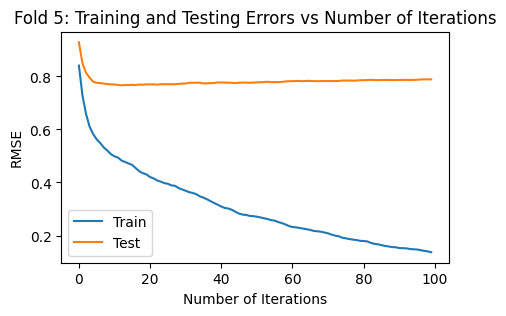


Cross-validation RMSE scores: [0.74, 0.75, 0.71, 0.77, 0.79]

Mean RMSE: 0.75


In [103]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_original = simplified_train_logs[['num_events', 'chars_per_min_process', 'words_per_min_product',
                                    'sentences_per_min_product', 'pause_time_proportion_perc',
                                    'mean_pause_length_w_in_words']]

y = train_scores.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Initialize lists to store results
max_values = []
min_values = []
rmse_scores = []

regr = XGBRegressor()

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X_original), 1):
    X_train, X_test = X_original.iloc[train_index], X_original.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA to the scaled features
    pca = PCA(n_components=3)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Concatenate the first 3 PCA components to the original features
    X_train_with_pca = np.hstack([X_train_pca, X_train])
    X_test_with_pca = np.hstack([X_test_pca, X_test])

    # Initialize lists to store errors for each fold
    train_errors_fold = []
    test_errors_fold = []

    # Fit the model on the training data
    regr.fit(X_train_with_pca, y_train, eval_metric="rmse", eval_set=[(X_train_with_pca, y_train), (X_test_with_pca, y_test)], verbose=False)
    # Get training and testing errors for each iteration of the current fold
    train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
    test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

    # Make predictions on the test data
    y_pred = regr.predict(X_test_with_pca)

    # Store max and min predicted values for each fold
    max_values.append(np.round(np.max(y_pred), 2))
    min_values.append(np.round(np.min(y_pred), 2))

    # Calculate RMSE for the fold
    rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
    rmse_scores.append(rmse)

    # Print results for each fold
    print(f"\nFold {fold}: Max Predicted Value: ", np.round(np.max(y_pred), 2),
          "; Min Predicted Value: ", np.round(np.min(y_pred), 2), f"; Fold RMSE: {rmse}")

    # Plot training and testing errors for the current fold
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(train_errors_fold, label='Train')
    ax.plot(test_errors_fold, label='Test')
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('RMSE')
    ax.legend()
    plt.title(f'Fold {fold}: Training and Testing Errors vs Number of Iterations')
    plt.show()

# Print average RMSE across all folds
print(f"\nCross-validation RMSE scores: {rmse_scores}")
print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


The result of the experiment with 3 added PCA Components does not show a satisfactory result: Mean RMSE of 0.75 vs base 0.74

#### Adding 4 PCA Components


Fold 1: Max Predicted Value:  5.68 ; Min Predicted Value:  1.04 ; Fold RMSE: 0.75


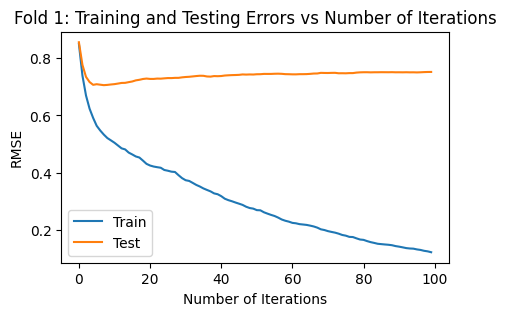


Fold 2: Max Predicted Value:  5.74 ; Min Predicted Value:  1.33 ; Fold RMSE: 0.75


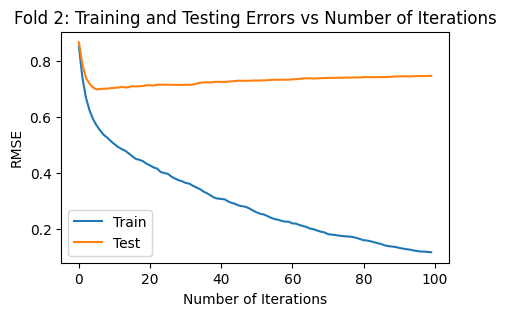


Fold 3: Max Predicted Value:  5.6 ; Min Predicted Value:  1.2 ; Fold RMSE: 0.7


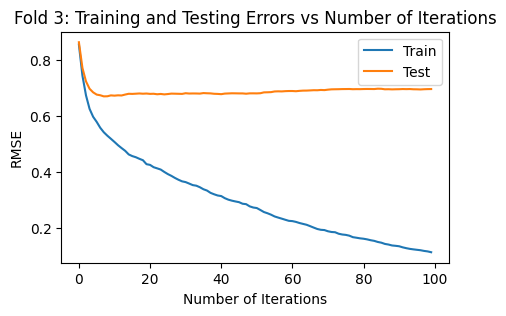


Fold 4: Max Predicted Value:  5.91 ; Min Predicted Value:  1.3 ; Fold RMSE: 0.74


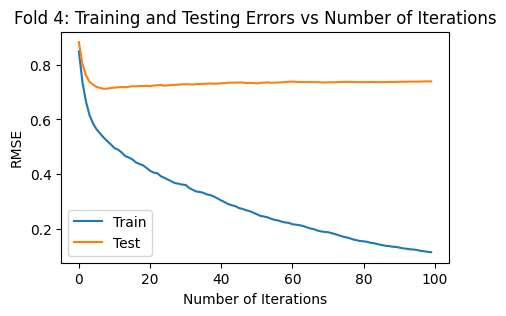


Fold 5: Max Predicted Value:  6.11 ; Min Predicted Value:  1.6 ; Fold RMSE: 0.79


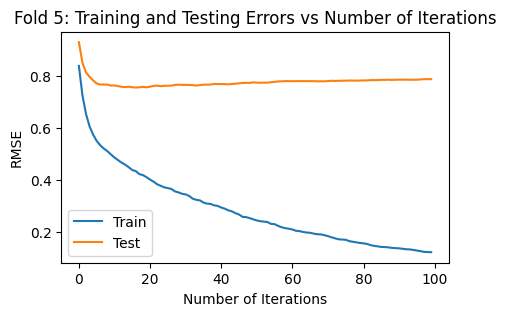


Cross-validation RMSE scores: [0.75, 0.75, 0.7, 0.74, 0.79]

Mean RMSE: 0.75


In [104]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

X_original = simplified_train_logs[['num_events', 'chars_per_min_process', 'words_per_min_product',
                                    'sentences_per_min_product', 'pause_time_proportion_perc',
                                    'mean_pause_length_w_in_words']]

y = train_scores.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Initialize lists to store results
max_values = []
min_values = []
rmse_scores = []

regr = XGBRegressor()

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X_original), 1):
    X_train, X_test = X_original.iloc[train_index], X_original.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA to the scaled features
    pca = PCA(n_components=4)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Concatenate the first 4 PCA components to the original features
    X_train_with_pca = np.hstack([X_train_pca, X_train])
    X_test_with_pca = np.hstack([X_test_pca, X_test])

    # Initialize lists to store errors for each fold
    train_errors_fold = []
    test_errors_fold = []

    # Fit the model on the training data
    regr.fit(X_train_with_pca, y_train, eval_metric="rmse", eval_set=[(X_train_with_pca, y_train), (X_test_with_pca, y_test)], verbose=False)
    # Get training and testing errors for each iteration of the current fold
    train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
    test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

    # Make predictions on the test data
    y_pred = regr.predict(X_test_with_pca)

    # Store max and min predicted values for each fold
    max_values.append(np.round(np.max(y_pred), 2))
    min_values.append(np.round(np.min(y_pred), 2))

    # Calculate RMSE for the fold
    rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
    rmse_scores.append(rmse)

    # Print results for each fold
    print(f"\nFold {fold}: Max Predicted Value: ", np.round(np.max(y_pred), 2),
          "; Min Predicted Value: ", np.round(np.min(y_pred), 2), f"; Fold RMSE: {rmse}")

    # Plot training and testing errors for the current fold
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(train_errors_fold, label='Train')
    ax.plot(test_errors_fold, label='Test')
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('RMSE')
    ax.legend()
    plt.title(f'Fold {fold}: Training and Testing Errors vs Number of Iterations')
    plt.show()

# Print average RMSE across all folds
print(f"\nCross-validation RMSE scores: {rmse_scores}")
print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


This time the cross-validation scores is different than before, yet the mean value stays the same: 0.75. Both experiments are dismissed.

### Replacing all features with the PCA components

#### 3 PCA Components


Fold 1: Max Predicted Value:  5.65 ; Min Predicted Value:  0.98 ; Fold RMSE: 0.84


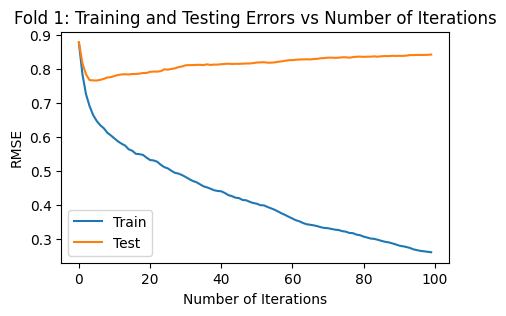


Fold 2: Max Predicted Value:  5.69 ; Min Predicted Value:  1.4 ; Fold RMSE: 0.83


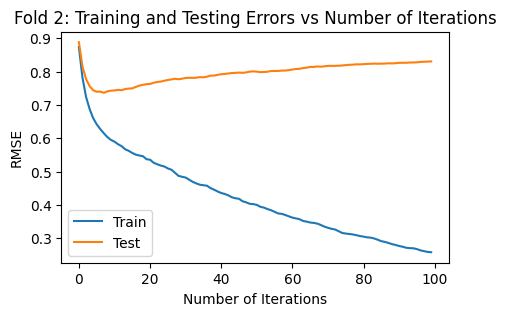


Fold 3: Max Predicted Value:  5.96 ; Min Predicted Value:  1.22 ; Fold RMSE: 0.79


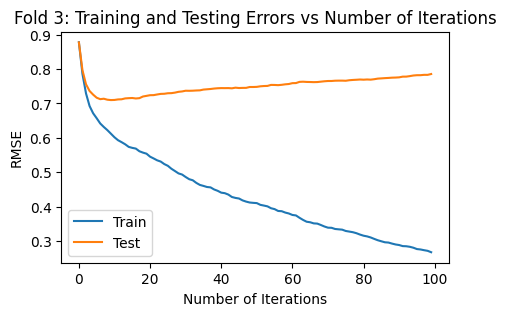


Fold 4: Max Predicted Value:  5.95 ; Min Predicted Value:  1.96 ; Fold RMSE: 0.84


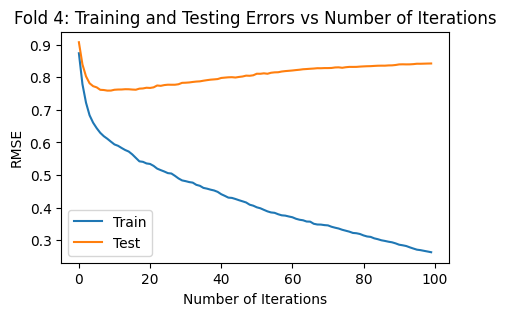


Fold 5: Max Predicted Value:  5.46 ; Min Predicted Value:  1.26 ; Fold RMSE: 0.85


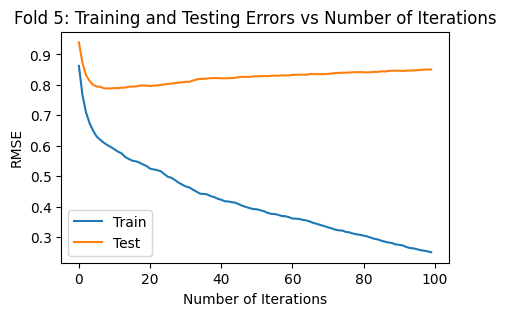


Cross-validation RMSE scores: [0.84, 0.83, 0.79, 0.84, 0.85]

Mean RMSE: 0.83


In [105]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_original = simplified_train_logs[['num_events', 'chars_per_min_process', 'words_per_min_product',
                                    'sentences_per_min_product', 'pause_time_proportion_perc',
                                    'mean_pause_length_w_in_words']]

y = train_scores.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Initialize lists to store results
max_values = []
min_values = []
rmse_scores = []

regr = XGBRegressor()

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X_original), 1):
    X_train, X_test = X_original.iloc[train_index], X_original.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA to the scaled features
    pca = PCA(n_components=3)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Initialize lists to store errors for each fold
    train_errors_fold = []
    test_errors_fold = []

    # Fit the model on the training data
    regr.fit(X_train_pca, y_train, eval_metric="rmse", eval_set=[(X_train_pca, y_train), (X_test_pca, y_test)], verbose=False)
    # Get training and testing errors for each iteration of the current fold
    train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
    test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

    # Make predictions on the test data
    y_pred = regr.predict(X_test_pca)

    # Store max and min predicted values for each fold
    max_values.append(np.round(np.max(y_pred), 2))
    min_values.append(np.round(np.min(y_pred), 2))

    # Calculate RMSE for the fold
    rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
    rmse_scores.append(rmse)

    # Print results for each fold
    print(f"\nFold {fold}: Max Predicted Value: ", np.round(np.max(y_pred), 2),
          "; Min Predicted Value: ", np.round(np.min(y_pred), 2), f"; Fold RMSE: {rmse}")

    # Plot training and testing errors for the current fold
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(train_errors_fold, label='Train')
    ax.plot(test_errors_fold, label='Test')
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('RMSE')
    ax.legend()
    plt.title(f'Fold {fold}: Training and Testing Errors vs Number of Iterations')
    plt.show()

# Print average RMSE across all folds
print(f"\nCross-validation RMSE scores: {rmse_scores}")
print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")

#### 4 PCA Components


Fold 1: Max Predicted Value:  5.61 ; Min Predicted Value:  1.47 ; Fold RMSE: 0.79


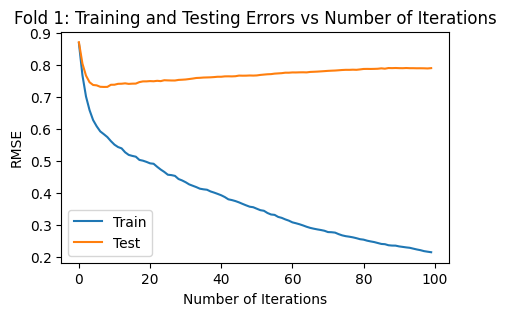


Fold 2: Max Predicted Value:  5.37 ; Min Predicted Value:  1.4 ; Fold RMSE: 0.8


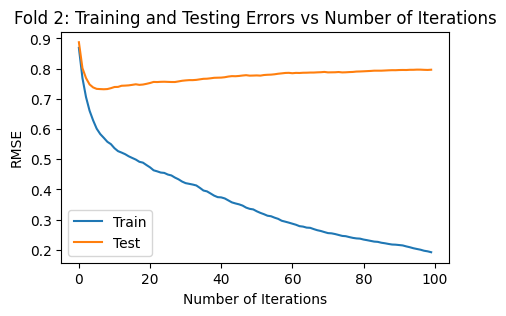


Fold 3: Max Predicted Value:  5.88 ; Min Predicted Value:  1.02 ; Fold RMSE: 0.76


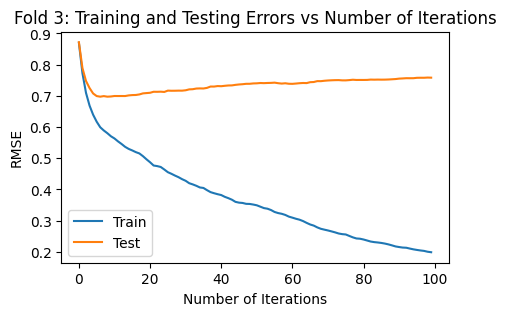


Fold 4: Max Predicted Value:  6.04 ; Min Predicted Value:  1.01 ; Fold RMSE: 0.81


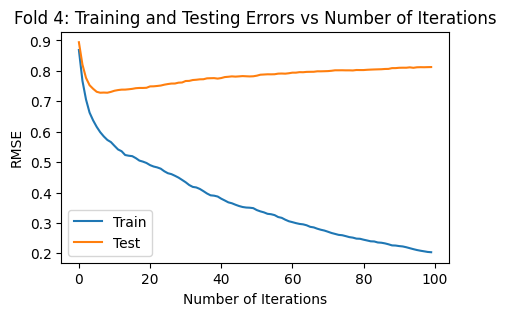


Fold 5: Max Predicted Value:  5.83 ; Min Predicted Value:  1.45 ; Fold RMSE: 0.83


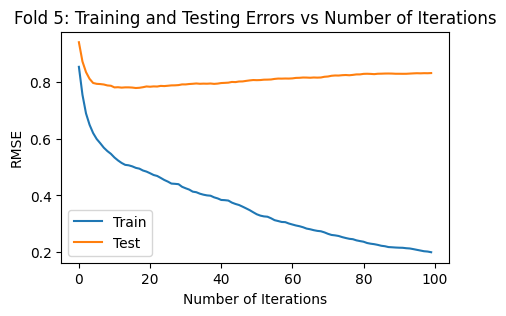


Cross-validation RMSE scores: [0.79, 0.8, 0.76, 0.81, 0.83]

Mean RMSE: 0.8


In [106]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_original = simplified_train_logs[['num_events', 'chars_per_min_process', 'words_per_min_product',
                                    'sentences_per_min_product', 'pause_time_proportion_perc',
                                    'mean_pause_length_w_in_words']]

y = train_scores.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Initialize lists to store results
max_values = []
min_values = []
rmse_scores = []

regr = XGBRegressor()

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X_original), 1):
    X_train, X_test = X_original.iloc[train_index], X_original.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA to the scaled features
    pca = PCA(n_components=4)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Initialize lists to store errors for each fold
    train_errors_fold = []
    test_errors_fold = []

    # Fit the model on the training data
    regr.fit(X_train_pca, y_train, eval_metric="rmse", eval_set=[(X_train_pca, y_train), (X_test_pca, y_test)], verbose=False)
    # Get training and testing errors for each iteration of the current fold
    train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
    test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

    # Make predictions on the test data
    y_pred = regr.predict(X_test_pca)

    # Store max and min predicted values for each fold
    max_values.append(np.round(np.max(y_pred), 2))
    min_values.append(np.round(np.min(y_pred), 2))

    # Calculate RMSE for the fold
    rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
    rmse_scores.append(rmse)

    # Print results for each fold
    print(f"\nFold {fold}: Max Predicted Value: ", np.round(np.max(y_pred), 2),
          "; Min Predicted Value: ", np.round(np.min(y_pred), 2), f"; Fold RMSE: {rmse}")

    # Plot training and testing errors for the current fold
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(train_errors_fold, label='Train')
    ax.plot(test_errors_fold, label='Test')
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('RMSE')
    ax.legend()
    plt.title(f'Fold {fold}: Training and Testing Errors vs Number of Iterations')
    plt.show()

# Print average RMSE across all folds
print(f"\nCross-validation RMSE scores: {rmse_scores}")
print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


The last two experiments show far worse results than the base model. All 4 PCA experiments are rejected.

### Standardizing


Fold 1: Max Predicted Value:  5.6 ; Min Predicted Value:  1.09 ; Fold RMSE: 0.75


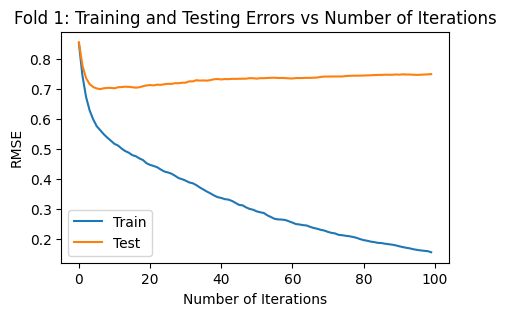


Fold 2: Max Predicted Value:  5.87 ; Min Predicted Value:  1.02 ; Fold RMSE: 0.73


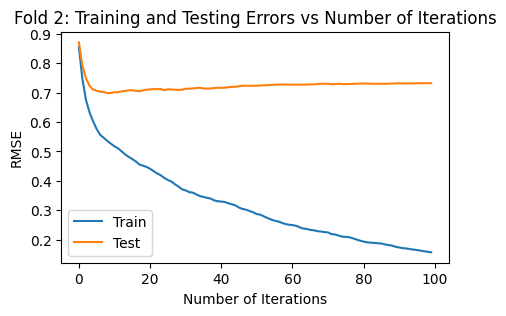


Fold 3: Max Predicted Value:  5.44 ; Min Predicted Value:  1.3 ; Fold RMSE: 0.67


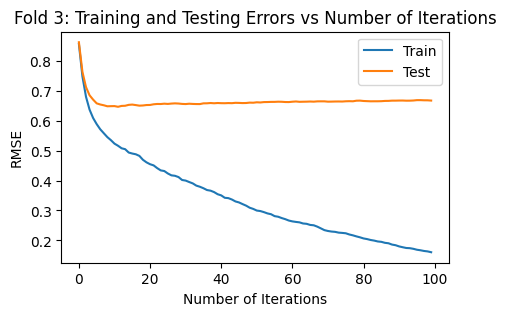


Fold 4: Max Predicted Value:  5.55 ; Min Predicted Value:  1.13 ; Fold RMSE: 0.76


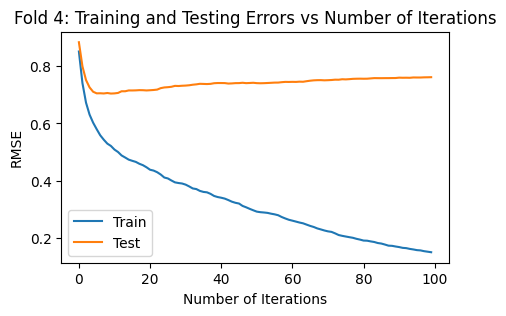


Fold 5: Max Predicted Value:  6.0 ; Min Predicted Value:  1.46 ; Fold RMSE: 0.8


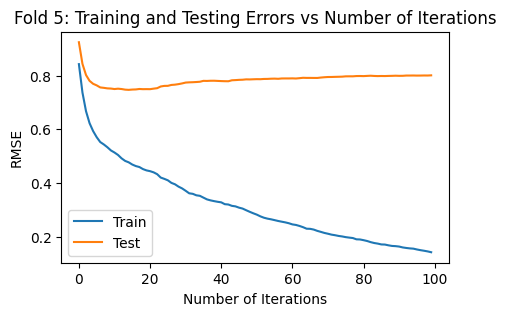


Cross-validation RMSE scores: [0.75, 0.73, 0.67, 0.76, 0.8]

Mean RMSE: 0.74


In [107]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler


X = simplified_train_logs[['num_events', 'chars_per_min_process', 'words_per_min_product',
                           'sentences_per_min_product', 'pause_time_proportion_perc',
                           'mean_pause_length_w_in_words']]

y = train_scores.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Initialize lists to store results
max_values = []
min_values = []
rmse_scores = []

regr = XGBRegressor()

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize lists to store errors for each fold
    train_errors_fold = []
    test_errors_fold = []
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit the model on the training data
    regr.fit(X_train_scaled, y_train, eval_metric="rmse", eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], verbose=False)

    # Get training and testing errors for each iteration of the current fold
    train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
    test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

    # Make predictions on the test data
    y_pred = regr.predict(X_test_scaled)

    # Store max and min predicted values for each fold
    max_values.append(np.round(np.max(y_pred), 2))
    min_values.append(np.round(np.min(y_pred), 2))

    # Calculate RMSE for the fold
    rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
    rmse_scores.append(rmse)

    # Print results for each fold
    print(f"\nFold {fold}: Max Predicted Value: ", np.round(np.max(y_pred), 2), "; Min Predicted Value: ", np.round(np.min(y_pred), 2), f"; Fold RMSE: {rmse}")

    # Plot training and testing errors for the current fold
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(train_errors_fold, label='Train')
    ax.plot(test_errors_fold, label='Test')
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('RMSE')
    ax.legend()
    plt.title(f'Fold {fold}: Training and Testing Errors vs Number of Iterations')
    plt.show()

# Print average RMSE across all folds
print(f"\nCross-validation RMSE scores: {rmse_scores}")
print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


Standardizing results in the base score: 0.74. The cross-validation RMSE scores are also identical to those in the base model, proving useless for XGBoost.

### Eliminating anomalies (essays with score 0.5)

Since there are only 5 essays with a score of 0.5, maybe the model will improve if we ignore them.

In [108]:
anomalies_idx = train_scores[train_scores.score==0.5].index
train_scores_ex_anomalies = train_scores.drop(train_scores.index[anomalies_idx])
simplified_train_logs_ex_anomalies = simplified_train_logs.drop(simplified_train_logs.index[anomalies_idx])

In [109]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

X = simplified_train_logs_ex_anomalies[['num_events',
                                        'chars_per_min_process', 
                                        'words_per_min_product',
                                        'sentences_per_min_product',
                                        'pause_time_proportion_perc',
                                        'mean_pause_length_w_in_words']]

y = train_scores_ex_anomalies.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Initialize lists to store results
rmse_scores = []

regr = XGBRegressor()

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

    # Get training and testing errors for each iteration of the current fold
    train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
    test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

    # Make predictions on the test data
    y_pred = regr.predict(X_test)

    # Calculate RMSE for the fold
    rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
    rmse_scores.append(rmse)

# Print average RMSE across all folds
print(f"\nCross-validation RMSE scores: {rmse_scores}")
print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


Cross-validation RMSE scores: [0.73, 0.76, 0.76, 0.74, 0.76]

Mean RMSE: 0.75


Once again, the performance worsens (0.75 vs 0.74), so experiment dismissed.

### Hyperparameters

We'll use Grid Search with a bunch of typical values for XGBoost hyperparameters and we'll keep one of the best combinations, 

considering Mean RMSE Score and Standard Deviation of cross-validation scores.

In [110]:
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBRegressor

X = simplified_train_logs[['num_events',
                           'chars_per_min_process', 
                           'words_per_min_product',
                           'sentences_per_min_product',
                           'pause_time_proportion_perc',
                           'mean_pause_length_w_in_words']]

y = train_scores.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Set the parameter grid for grid search
param_grid = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [20, 50, 100],
    'max_depth': [3, 4],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'alpha': [0, 0.3]
}

# Initialize XGBRegressor
regr = XGBRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(regr, param_grid, scoring='neg_root_mean_squared_error', cv=kf, verbose=1, n_jobs=-1)

# Fit the model on the training data using GridSearchCV
grid_search.fit(X, y)

# Get the results
results_df = pd.DataFrame(grid_search.cv_results_)

# Display top 5 combinations of parameters for the mean score
print("\nTop 5 combinations of parameters for the mean score:\n")
top_5_mean = results_df[results_df['rank_test_score'] <= 5]

# Sort by the absolute mean test score in ascending order
top_5_mean = top_5_mean.assign(abs_mean_test_score=top_5_mean['mean_test_score'].abs())
top_5_mean = top_5_mean.sort_values(by='abs_mean_test_score', ascending=True)

for index, row in top_5_mean.iterrows():
    print(f"Parameters: {row['params']}")
    print(f"Mean Test Score: {np.round(row['mean_test_score'],4)}")
    print(f"Standard Deviation: {np.round(row['std_test_score'],4)}\n")


Fitting 5 folds for each of 648 candidates, totalling 3240 fits

Top 5 combinations of parameters for the mean score:

Parameters: {'alpha': 0.3, 'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Mean Test Score: -0.6825
Standard Deviation: 0.0187

Parameters: {'alpha': 0, 'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Mean Test Score: -0.6827
Standard Deviation: 0.018

Parameters: {'alpha': 0, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Mean Test Score: -0.6831
Standard Deviation: 0.0171

Parameters: {'alpha': 0.3, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Mean Test Score: -0.6836
Standard Deviation: 0.0179

Parameters: {'alpha': 0.3, 'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_esti


Fold 1: Max Predicted Value:  5.17 ; Min Predicted Value:  1.45 ; Fold RMSE: 0.69


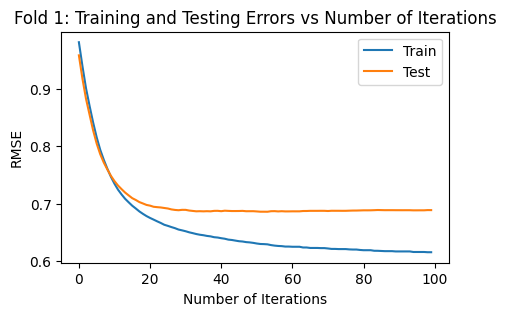


Fold 2: Max Predicted Value:  5.14 ; Min Predicted Value:  1.44 ; Fold RMSE: 0.68


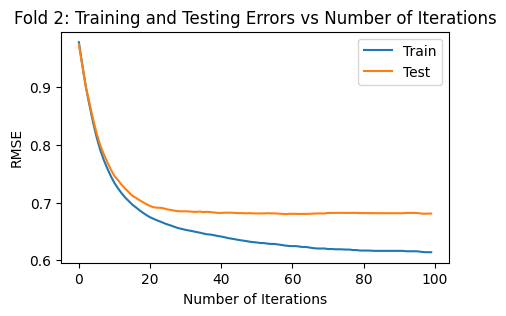


Fold 3: Max Predicted Value:  5.18 ; Min Predicted Value:  1.19 ; Fold RMSE: 0.65


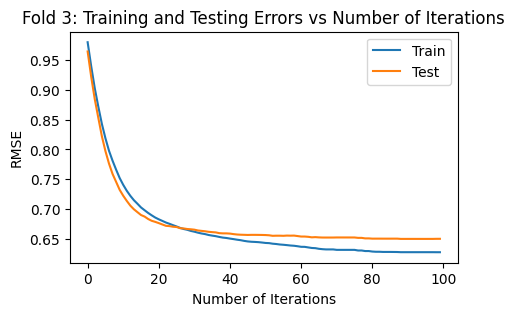


Fold 4: Max Predicted Value:  5.05 ; Min Predicted Value:  1.56 ; Fold RMSE: 0.68


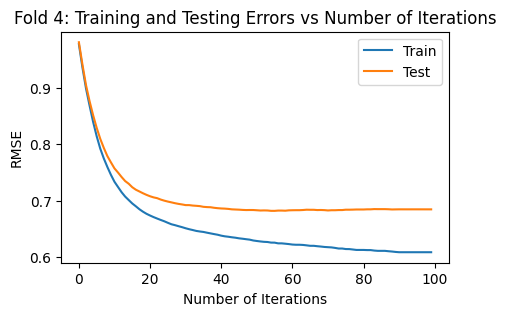


Fold 5: Max Predicted Value:  5.17 ; Min Predicted Value:  1.85 ; Fold RMSE: 0.71


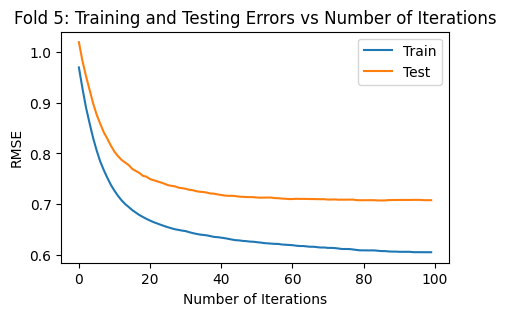


Cross-validation RMSE scores: [0.69, 0.68, 0.65, 0.68, 0.71]

Mean RMSE: 0.68


In [111]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

X = simplified_train_logs[['num_events',
                           'chars_per_min_process', 
                           'words_per_min_product',
                           'sentences_per_min_product',
                           'pause_time_proportion_perc',
                           'mean_pause_length_w_in_words']]

y = train_scores.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Initialize lists to store results
rmse_scores = []

regr = XGBRegressor(alpha=0.3, colsample_bytree=0.8, gamma=1, 
                    learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9)

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

    # Get training and testing errors for each iteration of the current fold
    train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
    test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

    # Make predictions on the test data
    y_pred = regr.predict(X_test)

    # Store max and min predicted values for each fold
    max_values.append(np.round(np.max(y_pred), 2))
    min_values.append(np.round(np.min(y_pred), 2))

    # Calculate RMSE for the fold
    rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
    rmse_scores.append(rmse)

    # Print results for each fold
    print(f"\nFold {fold}: Max Predicted Value: ", np.round(np.max(y_pred), 2), "; Min Predicted Value: ", np.round(np.min(y_pred), 2), f"; Fold RMSE: {rmse}")

    # Plot training and testing errors for the current fold
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(train_errors_fold, label='Train')
    ax.plot(test_errors_fold, label='Test')
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('RMSE')
    ax.legend()
    plt.title(f'Fold {fold}: Training and Testing Errors vs Number of Iterations')
    plt.show()

# Print average RMSE across all folds
print(f"\nCross-validation RMSE scores: {rmse_scores}")
print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")

## Preparation for submission

In [112]:
# Preparation for submission

regr.fit(X,y)      # Fitting the Model to the whole dataset

def transformations_train_test(df):     # Apply to test_logs the same transformations applied to train_logs

    id_groups = df.groupby('id')

    df['num_events'] = id_groups['event_id'].transform('last')

    df['input_chars_aux'] = id_groups['activity'].transform(lambda x: (x == 'Input').sum())

    df['remove_cut_chars_aux'] = id_groups['activity'].transform(
        lambda x: (df.loc[x.index, 'text_change'][x == 'Remove/Cut']).str.len().sum()
    )

    df['paste_chars_aux'] = id_groups['activity'].transform(
        lambda x: (df.loc[x.index, 'text_change'][x == 'Paste']).str.len().sum()
    )

    df['total_time_mins'] = np.round(id_groups['up_time'].transform('last') / 60000, 1)

    for _, group in id_groups:
        first_strings_replace_chars = 0
        second_strings_replace_chars = 0

        for replace_str in group[group.activity == "Replace"].text_change.values:
            arrow_idx = replace_str.find(' => ')
            first_strings_replace_chars += arrow_idx
            len_second_str = len(replace_str) - arrow_idx - len(' => ')
            second_strings_replace_chars += len_second_str

        df.loc[group.index, 'first_strings_replace_chars_aux'] = first_strings_replace_chars
        df.loc[group.index, 'second_strings_replace_chars_aux'] = second_strings_replace_chars

    df['chars_product'] = df.input_chars_aux - df.remove_cut_chars_aux - \
                          df.first_strings_replace_chars_aux + df.second_strings_replace_chars_aux + df.paste_chars_aux

    df['chars_process'] = df.input_chars_aux + df.second_strings_replace_chars_aux + \
                         df.paste_chars_aux
    df['chars_per_min_process'] = np.round(df.chars_process / df.total_time_mins, 1)


    df['last_word_count_aux'] = id_groups['word_count'].transform(lambda x: x.values[-1])
    df['words_per_min_product'] = np.round(df.last_word_count_aux / df.total_time_mins, 1)

    for _, group in id_groups:
        diff_word_count = group['word_count'].shift(1) - group['word_count']
        num_deleted_words = np.maximum(0, diff_word_count).sum()

        input_sentences = group[(group['text_change'].str.contains('[\.\;\?\!\:]', regex=True)) &
                                    (group.activity=='Input')].event_id.count()

        remove_cut_sentences = group[(group['text_change'].str.contains('[\.\;\?\!\:]', regex=True)) &
                                    (group.activity=='Remove/Cut')].event_id.count()

        input_paragraphs = group[(group.activity=='Input') & (group.text_change.str.contains('\n'))].event_id.count()

        df.loc[group.index, 'num_deleted_words_aux'] = num_deleted_words
        df.loc[group.index, 'input_sentences_aux'] = input_sentences
        df.loc[group.index, 'remove_cut_sentences_aux'] = remove_cut_sentences
        df.loc[group.index, 'input_paragraphs_aux'] = input_paragraphs

    sentences_process = df.input_sentences_aux
    sentences_product = df.input_sentences_aux - df.remove_cut_sentences_aux
    paragraphs_process = df.input_paragraphs_aux

    df = (
        df.assign(
            total_words_aux=lambda x: x['last_word_count_aux'] + x['num_deleted_words_aux'],
            sentences_per_min_product=lambda x: x['input_sentences_aux'] - \
                                                 x['remove_cut_sentences_aux'] / x['total_time_mins']
        )
        .round(1)
    )

    for _, group in id_groups:
        iki = group['down_time'] - group['up_time'].shift(1)
        filtered_iki = [num for num in iki if num >= 2000]
        num_pauses = len(filtered_iki)
        pause_time = sum(filtered_iki)

        # Assign accumulated values to the corresponding columns for the group
        df.loc[group.index, 'num_pauses'] = num_pauses
        df.loc[group.index, 'pause_time_aux'] = pause_time  

    df = (
        df.assign(
            pause_time_proportion_perc=np.round((100 * df.pause_time_aux) / (60000 * df.total_time_mins), 1)
        )
        .round(1)
    )

    for _, group in id_groups:
        group['word_count_up_aux'] = group.word_count > group.shift().word_count
        word_count_up_idxs = group[(group.word_count_up_aux) & (group.text_change=='q')].index

        pause_time_w_in_words, pauses_w_in_words = 0, 0
        for idx in word_count_up_idxs:
            initial_time = group.at[idx, 'up_time']
            slice_f = group[(group.index >= idx + 1) & (group.index <= idx + 10) 
                            & (group.activity=='Input') & (group.text_change.isin(['.', ',', ';', ':', ' ', '!', '?']))] 
            if not slice_f.empty:
                final_time = slice_f['down_time'].values[0]
                pause_time_w_in_words += final_time - initial_time
                pauses_w_in_words += 1

        df.loc[group.index, 'pause_time_w_in_words_aux'] = pause_time_w_in_words
        if pauses_w_in_words == 0:
            df.loc[group.index, 'pauses_w_in_words_aux'] = np.nan
        else:
            df.loc[group.index, 'pauses_w_in_words_aux'] = pauses_w_in_words

    df['mean_pause_length_w_in_words'] = np.round(df.pause_time_w_in_words_aux / \
                                                  df.pauses_w_in_words_aux, 1)

    df = df.filter(regex='^(?!.*aux).*$')
    df.drop(redundant_vars, axis=1, inplace=True)
    simplified_df = df.drop(original_cols_ex_id, axis=1)
    simplified_df.drop_duplicates(inplace=True)
    simplified_df.reset_index(drop=True, inplace=True)
    simplified_df.fillna(0, inplace=True)
    return simplified_df


test_logs_transformed = transformations_train_test(test_logs)
predictions = regr.predict(test_logs_transformed[['num_events', 'chars_per_min_process',
                                                  'words_per_min_product', 'sentences_per_min_product',
                                                  'pause_time_proportion_perc', 'mean_pause_length_w_in_words']])

# Constrain predictions to the nearest possible target value.
def discretize(predictions):
    score_values = np.array(sorted(train_scores.score.unique()))
    
    closest_values = score_values[np.argmin(np.abs(predictions[:, np.newaxis] - score_values), axis=1)]

    return closest_values

rounded_predictions = discretize(predictions)
test_logs_transformed['score'] = rounded_predictions
test_logs_transformed[['id', 'score']].to_csv('./submission.csv', index=False)